<a href="https://colab.research.google.com/github/enVives/TFG/blob/main/EvaluacioArquitectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import cv2
import random
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import wandb
import pylab as pl


from glob import glob
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from torchvision import transforms,models
from torch import nn
from torch.utils.data import Dataset
from google.colab import files
from IPython.display import clear_output,display
from google.colab.patches import cv2_imshow
from PIL import Image
from skimage import io

WEIGHTSANDBIASES = True
DOWNLOAD = False

if DOWNLOAD:
  !rm -rf /content/sample_data/*

  !kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

  !unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

#471be466c8949671a46c67e7aad0d5a0ac8c9dad

if WEIGHTSANDBIASES:
  wandb.login()

#torch.cuda.default_stream(torch.device('cuda'))

!rm -rf /content/sample_data/*

!kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

!unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

In [2]:
metadates = pd.read_csv('/content/sample_data/HAM10000_metadata.csv')
metadates = metadates.sort_values(by='image_id')
metadates.head()
print(metadates['dx'].value_counts())
print()
print(metadates['dx'].value_counts() / sum(metadates['dx'].value_counts()))

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

dx
nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: count, dtype: float64


nv: melanocytic nevi

vasc: vascular lesions

mel:melanoma

df: dermatofibroma

bkl: benign keratosis-like lesions

bcc: basal cell carcinoma

akiec: Actinic keratoses and intraepithelial carcinoma / Bowen's disease

In [3]:
class Formes(Dataset):
  #Classe on gestionarem les imatges dels fitxers
  dict_illnesses = {0 : 'nv', 1 : 'mel', 2 : 'bkl', 3 : 'bcc', 4 : 'akiec', 5 : 'vasc', 6 : 'df'}

  def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform
        #Per defecte pens que el color pot extreure característiques importants, per tant en primer lloc
        #entrenarem les imatges de color
        self.greyscale = False

  def __len__(self):
        return self.len

  def __addlabel__(self,label):
    self.labels = np.append(self.labels,label)

  def __addPath__(self,path):
    self.paths = np.append(self.paths,path)

  def __getdist__(self):
    return pd.Series(self.labels).value_counts()

  def __getlabels__(self):
    classes = [[],[],[],[],[],[],[]]
    for i in range(len(self.labels)):
      classes[self.labels[i]].append(i) #afegim l'index
    return classes

  def __redistribute__(self,percentages):
    #percentages: [15,15,10,10,5,5] percentatges que volem pujar de la resta de classes llevat de nv
    threshold = 0.005  #percentatge de marge que deixam a la redistribució
    Ntarget = self.len
    classes = self.__getlabels__() #indexos de cada clase
    afegir = np.array([0,0,0,0,0,0],dtype=np.int64) # de nv mai haurem d'afegir

    nmel = len(classes[1]) #nombre inicial de cada clase
    nbkl = len(classes[2])
    nbcc = len(classes[3])
    nakiec = len(classes[4])
    nvasc = len(classes[5])
    ndf = len(classes[6])

    while True:

      suma_actual = afegir.sum()

      operacio = percentages[0]*Ntarget - nmel
      afegir[0] +=  operacio if operacio > 0 else 0
      nmel += operacio if operacio > 0 else 0

      operacio = percentages[1]*Ntarget - nbkl
      afegir[1] += operacio if operacio > 0 else 0
      nbkl += operacio if operacio > 0 else 0

      operacio = percentages[2]*Ntarget - nbcc
      afegir[2] += operacio if operacio > 0 else 0
      nbcc += operacio if operacio > 0 else 0

      operacio = percentages[3]*Ntarget - nakiec
      afegir[3] += operacio if operacio > 0 else 0
      nakiec += operacio if operacio > 0 else 0

      operacio = percentages[4]*Ntarget - nvasc
      afegir[4] += operacio if operacio > 0 else 0
      nvasc += operacio if operacio > 0 else 0

      operacio = percentages[5]*Ntarget - ndf
      afegir[5] += operacio if operacio > 0 else 0
      ndf += operacio if operacio > 0 else 0

      if (afegir.sum()-suma_actual) < Ntarget*threshold:
        break

      Ntarget += (afegir.sum()-suma_actual)

    #Quedaria afegir a les imatges les còpies
    for i in range(len(afegir)):
      for j in range(afegir[i]):

          self.__addPath__(self.paths[classes[i+1][random.randint(0, len(classes[i+1]) - 1)]])
          self.__addlabel__(i+1)

    self.len = len(self.labels)

  def __setgreyscale__(self,mode):
    self.greyscale = mode

  def __getitem__(self, index):
      path = self.paths[index]
      label = self.labels[index]

      image = cv2.imread(path, cv2.IMREAD_GRAYSCALE if self.greyscale else cv2.IMREAD_COLOR)

      if self.greyscale:
        image = Image.fromarray(image, mode="L")
      else:
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      image = self.transform(image)

      return image, label

In [4]:
def calcula_mitjana_desviacio(img_files_path):
  mitjana = np.array([0.0, 0.0, 0.0], dtype=np.float64)
  desviacio = np.array([0.0, 0.0, 0.0], dtype=np.float64)

  x,y = 256,256
  pixels_totals_canal = len(img_files_path) * x * y

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)

    mitjana += np.array([canal_r.sum(), canal_g.sum(), canal_b.sum()])
    #desviacio += np.array([(canal_r**2).sum(), (canal_g**2).sum(), (canal_b**2).sum()])

  mitjana = mitjana / pixels_totals_canal

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)
    desviacio += np.array([((canal_r-mitjana[0])**2).sum(), ((canal_g-mitjana[1])**2).sum(), ((canal_b-mitjana[2])**2).sum()])


  desviacio = np.sqrt(desviacio / pixels_totals_canal)

  return mitjana,desviacio

In [5]:
def load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

  illnes_dictionary = {
      'nv': 'Melanocytic nevi',
      'mel': 'Melanoma',
      'bkl': 'Benign keratosis-like lesions ',
      'bcc': 'Basal cell carcinoma',
      'akiec': 'Actinic keratoses and intraepithelial carcinoma / Bowens disease',
      'vasc': 'Vascular lesions',
      'df': 'Dermatofibroma'
  }

  img_files_1 = sorted(glob('/content/sample_data/HAM10000_images_part_1/*'))
  img_files_2 = sorted(glob('/content/sample_data/HAM10000_images_part_2/*'))
  img_files = img_files_1 + img_files_2

  img_files = np.array(img_files)


  imgid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in img_files}

  metadates['path'] = metadates['image_id'].map(imgid_path_dict.get)
  metadates['illness'] = metadates['dx'].map(illnes_dictionary.get)
  metadates['illness_code'] = metadates['dx'].map({'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6})

  #Aquest illness_code s'utilitzarà com a label de la enfermetat

  img_number = len(img_files)

  X = metadates.drop('illness_code',axis= 1)
  y = metadates['illness_code']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testing_dist, random_state=42, stratify=y)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valitation_dist/(training_dist+valitation_dist), random_state=42, stratify=y_train)

  #Una bona idea seria aplicar data augmentation al conjunt d'entrenament ja que les classes estan molt desbalancejades
  #Una altra bona idea seria emplear una funció de pèrdua que tengui en compte les classes desbalancejades.

  #Antes de guardar els datasets en classes Formes, hauriem de caluclar la mitjana i desviació típica de les imatges
  train_data = Formes(X_train['path'].to_numpy(),y_train.to_numpy(),transformation_training)
  test_data = Formes(X_test['path'].to_numpy(),y_test.to_numpy(),transformation_default)
  validation_data = Formes(X_val['path'].to_numpy(),y_val.to_numpy(),transformation_default)


  #prova1: [0.12,0.12,0.06,0.04,0.02,0.02]
  #prova2: [0.12,0.12,0.06,0.04,0.02,0.015]
  #prova3: [0.13,0.13,0.07,0.05,0.02,0.015]

  if distribution != None:
    train_data.__redistribute__(distribution)

  print(train_data.__getdist__())
  print(train_data.len)

  return train_data, test_data,validation_data


In [6]:
def veure_imatges(train_data,std,mean):
  for i in range(len(train_data)):
    imatge,label = train_data.__getitem__(i)

    imatge = imatge * (std[:, None, None]*255) + (mean[:, None, None]*255)

    # Convert the tensor back to a NumPy array
    img_numpy = imatge.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    cv2_imshow(img_numpy)
    time.sleep(5)
    clear_output(wait=True)

In [7]:
def get_weights():
  #diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}
  valors = metadates['dx'].value_counts()
  print(valors)
  illnesses = valors.keys()
  weights = np.zeros(len(illnesses))

  i = 0
  for x in illnesses:
    y = valors[x]
    weights[i] = valors.sum() / y
    i+= 1



  weights[1] *= 2.0
  weights[3] *= 2.0
  weights[4] *= 2.0



  print(weights)
  weights = weights / weights.sum()
  print(weights)
  print(weights[1]+weights[3]+weights[4])

get_weights()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64
[ 1.49366145 17.99640611  9.11282985 38.9688716  61.25382263 70.52816901
 87.08695652]
[0.00521456 0.06282768 0.03181402 0.13604515 0.21384468 0.24622257
 0.30403135]
0.41271751274017043


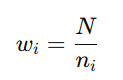

[0.00657042, **0.03958192**, 0.04008614, **0.08570948**, **0.13472377**, 0.31024417,
 0.3830841 ]

 provarem a augmentar en 1.5 els pesos de les enfermetats perilloses:

[0.00581449, 0.05254201, 0.03547423, 0.11377288, 0.17883566, 0.27455052,
 0.33901021]

 i en 2.0:

 [0.00521456, 0.06282768, 0.03181402, 0.13604515, 0.21384468, 0.24622257,
 0.30403135]

 Això pujarà el pes conjunt de les classes perilloses fins a 41%

In [8]:
#veure_imatges(train_data,std,mean)

Ara ja tenim el training preparat. El provarem amb el validation a continuació

##ENTRENAMENT

In [9]:
def tria_model(numero_model,weights):
  if numero_model == 0:
    alexnetbinary = models.alexnet(weights=weights)

    alexnetbinary.classifier = nn.Sequential(
    torch.nn.Linear(9216, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 512),
    nn.ReLU(),
    torch.nn.Linear(512, 1)
    )
    loss_fn = nn.BCEWithLogitsLoss()

    return alexnetbinary,loss_fn

  elif numero_model == 1:
    vggbinary = models.vgg19(weights=weights)
    vggbinary.classifier[6] = nn.Linear(in_features=4096, out_features=1)
    loss_fn = nn.BCEWithLogitsLoss()

    return vggbinary,loss_fn

  elif numero_model == 2:
    # alexnetmulticlass = models.alexnet(weights=None)

    # alexnetmulticlass.classifier = nn.Sequential(
    # torch.nn.Linear(9216, 1024),
    # nn.ReLU(),
    # torch.nn.Linear(1024, 1024),
    # nn.ReLU(),
    # torch.nn.Linear(1024, 512),
    # nn.ReLU(),
    # torch.nn.Linear(512, 7),  # Ja que tenim 7 classes.
    # nn.Softmax(dim=1)
    # )
    # loss_fn = nn.CrossEntropyLoss()

    # return alexnetmulticlass,loss_fn
    return




In [10]:
def converteix_a_binari(target):
  #{'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}
  diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}
  target = ([[str(num.item())] for num in target])

  mapped_tensor = torch.tensor([[diseases[num[0]]] for num in target])
  return mapped_tensor

In [11]:
def train(model,loss_fn,dataloader,optimizer,epoch,device):

  train_acc = 0
  train_f1 = 0
  train_recall = 0
  train_precision = 0
  train_loss = 0

  for batch_num, (input_img, target) in tqdm(enumerate(dataloader), desc=f"Batches (Època {epoch})"):
        model.train()
        optimizer.zero_grad()

        target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
        target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no
        target = target.to(device)


        input_img = input_img.to(device)
        output = model(input_img.to(device))

        loss = loss_fn(output, target.float())

        output = torch.sigmoid(output)

        output = (output.cpu().detach().numpy() > 0.5).astype(int)

        target = target.cpu().detach().numpy()

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            optimizer.step()

        #print(f"Pèrdua entrenament batch: {batch_num} epoch: {epoch+1}  train_loss: {loss.item()}")
        train_acc += accuracy_score(target,output)
        train_f1 += f1_score(target,output,zero_division=1)
        train_recall += recall_score(target,output,zero_division=1)
        train_precision += precision_score(target,output,zero_division=1)
        train_loss += loss.item()

  return train_acc,train_f1,train_recall,train_precision,train_loss


In [12]:
def validate(model,loss_fn,data_loader,device):
  val_acc = 0
  val_f1 = 0
  val_recall = 0
  val_precision = 0
  val_loss = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):
            input_img = input_img.to(device)


            target = torch.unsqueeze(target, 1)
            target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no
            target = target.to(device)

            output = model(input_img)
            loss = loss_fn(output, target.float())

            output = torch.sigmoid(output)
            output = (output.cpu().detach().numpy() > 0.5).astype(int)
            target = target.cpu().detach().numpy()

            val_acc  += accuracy_score(target,output)
            val_f1 += f1_score(target,output,zero_division=1)
            val_recall += recall_score(target,output,zero_division=1)
            val_precision += precision_score(target,output,zero_division=1)

            val_loss += loss.item()

  return val_acc,val_f1,val_recall,val_precision,val_loss

In [13]:
def execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,epochs,device):

  t_loss = np.zeros(epochs)
  v_loss = np.zeros(epochs)
  acc_t = np.zeros(epochs)
  acc_v = np.zeros(epochs)
  f1_t = np.zeros(epochs)
  f1_v = np.zeros(epochs)
  recall_t = np.zeros(epochs)
  recall_v = np.zeros(epochs)
  architecrures_inv = {0: 'alexnet',1:'vgg',2:'resnet'}

  patiente = 7
  best_recall = 0

  pbar = tqdm(range(1, epochs + 1))  # tdqm permet tenir text dinàmic

  for epoch in pbar:

      train_loss = 0
      train_acc = 0
      train_precision = 0
      train_f1 = 0
      train_recall = 0
      val_acc = 0
      val_recall = 0
      val_f1 = 0
      val_loss = 0
      val_precision = 0

      batch_num = 1

      train_acc,train_f1,train_recall,train_precision,train_loss = train(model,loss_fn,train_loader,optimizer,epoch,device)

      val_acc,val_f1,val_recall,val_precision,val_loss  = validate(model,loss_fn,val_loader,device)

      if WEIGHTSANDBIASES:

        training_metrics = {"train/train_loss": train_loss/len(train_loader),
                        "train/train_acc":train_acc/len(train_loader),
                        "train/train_f1":train_f1/len(train_loader),
                        "train/train_recall":train_recall/len(train_loader),
                        "train/train_precision":train_precision/len(train_loader)}

        val_metrics = {"val/val_loss": val_loss/len(val_loader),
                      "val/val_acc":val_acc/len(val_loader),
                      "val/val_f1":val_f1/len(val_loader),
                      "val/val_recall": val_recall/len(val_loader),
                      "val/val_precision": val_precision/len(val_loader)}

        wandb.log({**training_metrics, **val_metrics})

        # torch.save(model, "my_model.pt")
        # wandb.log_model("./my_model.pt", architecrures_inv[MODEL], aliases=[f"epoch-{epoch+1}"])

      # RESULTATS
      train_loss /= len(train_loader)
      train_acc /= len(train_loader)
      train_f1 /= len(train_loader)
      train_recall /= len(train_loader)
      train_precision /= len(train_loader)

      print(f"Pèrdua entrenament epoch: {epoch}  train_loss: {train_loss}")
      print(f"Accuracy train epoch: {epoch}  train_acc: {train_acc}")
      print(f"F1 train epoch: {epoch}  train_f1: {train_f1}")
      print(f"Recall train epoch: {epoch}  train_recall: {train_recall}")

      val_loss /= len(val_loader)
      val_acc /= len(val_loader)
      val_f1 /= len(val_loader)
      val_recall /= len(val_loader)

      print()
      print()
      print(f"Pèrdua validació epoch: {epoch}  val_loss: {val_loss}")
      print(f"Accuracy val epoch: {epoch}  val_acc: {val_acc}")
      print(f"F1 val epoch: {epoch}  val_f1: {val_f1}")
      print(f"Recall val epoch: {epoch}  val_reall: {val_recall}")

      if val_recall > best_recall:
        best_recall = val_recall
        patiente = 7
      else:
        patiente -= 1

      if patiente == 0:
        print("Early Sopping")
        break

  wandb.finish()

In [14]:
from itertools import product
BINARY = True #Si volem que el resultat de la classificació sigui 0 i 1

architectures = {'alexnet': 0,'vgg': 1,'resnet': 2}
MODEL = architectures['alexnet']

TRAINING = 0.64
VALIDATION = 0.16
TESTING = 0.20
SIZE = 224


mean = torch.tensor([194.57463374, 139.13953272, 145.36132088]) /255 #rgb
std = torch.tensor([35.92275236, 38.90347617, 43.33101831]) / 255

TRANSFORMATIONS = []
DISTRIBUTIONS = None


transform = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std)
])

transform_training = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=20),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
    #transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std),
])

#load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

train_data,validation_data,test_data = load_sets(transform_training,transform,TRAINING,VALIDATION,TESTING,DISTRIBUTIONS)

#Realitzar el tuning de hiperparàmetres aquí


EPOCHS = 100
BATCH_SIZE = [32,64]

WEIGHTS = [[0.00657042, 0.03958192, 0.04008614, 0.08570948, 0.13472377, 0.31024417, 0.3830841 ],[0.00581449, 0.05254201, 0.03547423, 0.11377288, 0.17883566, 0.27455052, 0.33901021],
 [0.00521456, 0.06282768, 0.03181402, 0.13604515, 0.21384468, 0.24622257, 0.30403135]]

LEARNING_RATE = [1e-3,1e-4]

for batch_size,weights,learning_rate in product(BATCH_SIZE,WEIGHTS,LEARNING_RATE):

  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

  model,loss_fn = tria_model(MODEL,weights)


  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)

  projectes = ['Ham10000-AlexnetBinary','Ham1000-Vgg','Ham1000-ResNet']

  #print(f"{batch_size} , {weights} , {learning_rate}")
  if WEIGHTSANDBIASES:
      wandb.init(
              project=projectes[MODEL],
              config={
                  "epochs": EPOCHS,
                  "batch_size": batch_size,
                  "lr": learning_rate,
                  "trsize":len(train_loader),
                  "trdist":TRAINING,
                  "vsize":len(val_loader),
                  "vdist":VALIDATION,
                  "weights":weights,
                  })
      config = wandb.config
      print(config)

  execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,EPOCHS,device)

0    4291
1     712
2     703
3     329
4     209
5      91
6      74
Name: count, dtype: int64
6409


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 157MB/s]
wandb: Currently logged in as: pjvivesmorey (pjvivesmorey-uib). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


{'epochs': 100, 'batch_size': 32, 'lr': 0.001, 'trsize': 201, 'trdist': 0.64, 'vsize': 63, 'vdist': 0.16, 'weights': [0.00657042, 0.03958192, 0.04008614, 0.08570948, 0.13472377, 0.31024417, 0.3830841]}


  0%|          | 0/100 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 0.42748924244695635
Accuracy train epoch: 1  train_acc: 0.8050200386954118
F1 train epoch: 1  train_f1: 0.07236307736746718
Recall train epoch: 1  train_recall: 0.059441070261965795


Pèrdua validació epoch: 1  val_loss: 0.3673077377061995
Accuracy val epoch: 1  val_acc: 0.8038586048454469
F1 val epoch: 1  val_f1: 0.0
Recall val epoch: 1  val_reall: 0.0


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 0.3962268765589491
Accuracy train epoch: 2  train_acc: 0.812465450525152
F1 train epoch: 2  train_f1: 0.16783755135379363
Recall train epoch: 2  train_recall: 0.14052698269116176


Pèrdua validació epoch: 2  val_loss: 0.44452224979324945
Accuracy val epoch: 2  val_acc: 0.6734022556390977
F1 val epoch: 2  val_f1: 0.5122454363595197
Recall val epoch: 2  val_reall: 0.9303917863441672


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.3818351010703922
Accuracy train epoch: 3  train_acc: 0.804726368159204
F1 train epoch: 3  train_f1: 0.0817817925613314
Recall train epoch: 3  train_recall: 0.08480012248668964


Pèrdua validació epoch: 3  val_loss: 0.39287511815154363
Accuracy val epoch: 3  val_acc: 0.8157894736842105
F1 val epoch: 3  val_f1: 0.402487135750441
Recall val epoch: 3  val_reall: 0.35874676469914557


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.3827369250171813
Accuracy train epoch: 4  train_acc: 0.8123272526257601
F1 train epoch: 4  train_f1: 0.13143517621129563
Recall train epoch: 4  train_recall: 0.11031315285046628


Pèrdua validació epoch: 4  val_loss: 0.3832187725911065
Accuracy val epoch: 4  val_acc: 0.8058688387635755
F1 val epoch: 4  val_f1: 0.003527336860670194
Recall val epoch: 4  val_reall: 0.001984126984126984


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.38242279734481033
Accuracy train epoch: 5  train_acc: 0.8096842177998894
F1 train epoch: 5  train_f1: 0.1283008288495558
Recall train epoch: 5  train_recall: 0.11575456053067992


Pèrdua validació epoch: 5  val_loss: 0.37446921023111496
Accuracy val epoch: 5  val_acc: 0.8114557226399332
F1 val epoch: 5  val_f1: 0.13141884570456003
Recall val epoch: 5  val_reall: 0.08397541611827325


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.36717888683228944
Accuracy train epoch: 6  train_acc: 0.8110834715312327
F1 train epoch: 6  train_f1: 0.1850878827901608
Recall train epoch: 6  train_recall: 0.15678659372689213


Pèrdua validació epoch: 6  val_loss: 0.37140894645736333
Accuracy val epoch: 6  val_acc: 0.8255534670008354
F1 val epoch: 6  val_f1: 0.3372611152723196
Recall val epoch: 6  val_reall: 0.2549651847270895


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.37367484003157164
Accuracy train epoch: 7  train_acc: 0.8151948590381426
F1 train epoch: 7  train_f1: 0.16961946290304503
Recall train epoch: 7  train_recall: 0.1382115673160449


Pèrdua validació epoch: 7  val_loss: 0.36099720781757716
Accuracy val epoch: 7  val_acc: 0.8179041353383458
F1 val epoch: 7  val_f1: 0.1868342415961463
Recall val epoch: 7  val_reall: 0.12552337433289815


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.3721056622059191
Accuracy train epoch: 8  train_acc: 0.8094596462133775
F1 train epoch: 8  train_f1: 0.14611134808676507
Recall train epoch: 8  train_recall: 0.1286487834995297


Pèrdua validació epoch: 8  val_loss: 0.3735868370249158
Accuracy val epoch: 8  val_acc: 0.8304876775271512
F1 val epoch: 8  val_f1: 0.4241823950507422
Recall val epoch: 8  val_reall: 0.3577242862957148


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.3596135436450664
Accuracy train epoch: 9  train_acc: 0.8186843559977888
F1 train epoch: 9  train_f1: 0.22246490949300424
Recall train epoch: 9  train_recall: 0.1891909500118455


Pèrdua validació epoch: 9  val_loss: 0.3908162301494962
Accuracy val epoch: 9  val_acc: 0.806704260651629
F1 val epoch: 9  val_f1: 0.006172839506172838
Recall val epoch: 9  val_reall: 0.003427128427128427
Early Sopping


train/train_acc,▁▅▁▅▃▄▆▃█
train/train_f1,▁▅▁▄▄▆▆▄█
train/train_loss,█▅▃▃▃▂▂▂▁
train/train_precision,█▄█▆▄▁▄▄▃
train/train_recall,▁▅▂▄▄▆▅▅█
val/val_acc,▇▁▇▇▇█▇█▇
val/val_f1,▁█▇▁▃▆▄▇▁
val/val_loss,▂█▄▃▂▂▁▂▃
val/val_precision,█▁▃█▅▄▆▄█
val/val_recall,▁█▄▁▂▃▂▄▁
train/train_acc,0.81868


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


{'epochs': 100, 'batch_size': 32, 'lr': 0.0001, 'trsize': 201, 'trdist': 0.64, 'vsize': 63, 'vdist': 0.16, 'weights': [0.00657042, 0.03958192, 0.04008614, 0.08570948, 0.13472377, 0.31024417, 0.3830841]}


  0%|          | 0/100 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 0.36751447729210357
Accuracy train epoch: 1  train_acc: 0.8287382531785517
F1 train epoch: 1  train_f1: 0.33648341712317476
Recall train epoch: 1  train_recall: 0.2987336461217059


Pèrdua validació epoch: 1  val_loss: 0.3620715131835332
Accuracy val epoch: 1  val_acc: 0.8566207184628237
F1 val epoch: 1  val_f1: 0.5523799600130134
Recall val epoch: 1  val_reall: 0.5047974071783596


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 0.32037625914041085
Accuracy train epoch: 2  train_acc: 0.8541666666666666
F1 train epoch: 2  train_f1: 0.515843728199854
Recall train epoch: 2  train_recall: 0.47482893005281057


Pèrdua validació epoch: 2  val_loss: 0.34057687175652335
Accuracy val epoch: 2  val_acc: 0.8319757727652465
F1 val epoch: 2  val_f1: 0.23936213698118464
Recall val epoch: 2  val_reall: 0.1573444192491811


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.29909236503032904
Accuracy train epoch: 3  train_acc: 0.8639441680486456
F1 train epoch: 3  train_f1: 0.5647152190486805
Recall train epoch: 3  train_recall: 0.5369288119288116


Pèrdua validació epoch: 3  val_loss: 0.30830661278395427
Accuracy val epoch: 3  val_acc: 0.848031537176274
F1 val epoch: 3  val_f1: 0.3485477485477486
Recall val epoch: 3  val_reall: 0.2447341899722852


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.2808879225778936
Accuracy train epoch: 4  train_acc: 0.8735143725815367
F1 train epoch: 4  train_f1: 0.5966714809572973
Recall train epoch: 4  train_recall: 0.5536512961886096


Pèrdua validació epoch: 4  val_loss: 0.28686096318184384
Accuracy val epoch: 4  val_acc: 0.8749738930659984
F1 val epoch: 4  val_f1: 0.5649838282891503
Recall val epoch: 4  val_reall: 0.4666264951979239


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.27215826589224945
Accuracy train epoch: 5  train_acc: 0.8794223327805417
F1 train epoch: 5  train_f1: 0.624980632992097
Recall train epoch: 5  train_recall: 0.5967326206132176


Pèrdua validació epoch: 5  val_loss: 0.2710302483940881
Accuracy val epoch: 5  val_acc: 0.8855472013366751
F1 val epoch: 5  val_f1: 0.6268623019212729
Recall val epoch: 5  val_reall: 0.5357114226161844


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.2586877843485543
Accuracy train epoch: 6  train_acc: 0.8878869541182973
F1 train epoch: 6  train_f1: 0.6600032942530978
Recall train epoch: 6  train_recall: 0.6165186527126822


Pèrdua validació epoch: 6  val_loss: 0.28665997383613434
Accuracy val epoch: 6  val_acc: 0.8738251879699248
F1 val epoch: 6  val_f1: 0.566997802951658
Recall val epoch: 6  val_reall: 0.46998178188654377


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.24516278342228032
Accuracy train epoch: 7  train_acc: 0.8929484521835268
F1 train epoch: 7  train_f1: 0.6778314353114498
Recall train epoch: 7  train_recall: 0.6442961957887328


Pèrdua validació epoch: 7  val_loss: 0.2727191914168615
Accuracy val epoch: 7  val_acc: 0.8797514619883041
F1 val epoch: 7  val_f1: 0.6267969222340444
Recall val epoch: 7  val_reall: 0.5746673080006415


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.24030847610229283
Accuracy train epoch: 8  train_acc: 0.8968352681039248
F1 train epoch: 8  train_f1: 0.6791972358293232
Recall train epoch: 8  train_recall: 0.6407378690960777


Pèrdua validació epoch: 8  val_loss: 0.29947895284682985
Accuracy val epoch: 8  val_acc: 0.8726764828738512
F1 val epoch: 8  val_f1: 0.528841369548957
Recall val epoch: 8  val_reall: 0.4279850660803041


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.2278745063575939
Accuracy train epoch: 9  train_acc: 0.8978372028745163
F1 train epoch: 9  train_f1: 0.6839662994854533
Recall train epoch: 9  train_recall: 0.6451864056341664


Pèrdua validació epoch: 9  val_loss: 0.2882671861184968
Accuracy val epoch: 9  val_acc: 0.8720238095238095
F1 val epoch: 9  val_f1: 0.6183965145198149
Recall val epoch: 9  val_reall: 0.6012471655328798


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.21480206544719524
Accuracy train epoch: 10  train_acc: 0.9070964621337756
F1 train epoch: 10  train_f1: 0.7222054249274956
Recall train epoch: 10  train_recall: 0.6932175342623101


Pèrdua validació epoch: 10  val_loss: 0.27279211285095367
Accuracy val epoch: 10  val_acc: 0.8860693400167085
F1 val epoch: 10  val_f1: 0.5908632580201206
Recall val epoch: 10  val_reall: 0.5017235850569184


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.2025613312549259
Accuracy train epoch: 11  train_acc: 0.9182213930348259
F1 train epoch: 11  train_f1: 0.7514699207181071
Recall train epoch: 11  train_recall: 0.7178111965425397


Pèrdua validació epoch: 11  val_loss: 0.324859090385929
Accuracy val epoch: 11  val_acc: 0.8713450292397661
F1 val epoch: 11  val_f1: 0.5342106669137483
Recall val epoch: 11  val_reall: 0.4526220252410728


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.19653810857243798
Accuracy train epoch: 12  train_acc: 0.9136954118297401
F1 train epoch: 12  train_f1: 0.7419006583158565
Recall train epoch: 12  train_recall: 0.7121999062297568


Pèrdua validació epoch: 12  val_loss: 0.3212145512539243
Accuracy val epoch: 12  val_acc: 0.8681860902255639
F1 val epoch: 12  val_f1: 0.5138508757556378
Recall val epoch: 12  val_reall: 0.4036911060720585


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.19057745225171543
Accuracy train epoch: 13  train_acc: 0.9161138750690989
F1 train epoch: 13  train_f1: 0.7484665928781666
Recall train epoch: 13  train_recall: 0.7311460374893209


Pèrdua validació epoch: 13  val_loss: 0.2899296092726881
Accuracy val epoch: 13  val_acc: 0.8759659565580619
F1 val epoch: 13  val_f1: 0.5880775775733759
Recall val epoch: 13  val_reall: 0.5050390526581003


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.17032527919877227
Accuracy train epoch: 14  train_acc: 0.9273942786069652
F1 train epoch: 14  train_f1: 0.7845892059479699
Recall train epoch: 14  train_recall: 0.7612839482242465


Pèrdua validació epoch: 14  val_loss: 0.32128844197307316
Accuracy val epoch: 14  val_acc: 0.873172514619883
F1 val epoch: 14  val_f1: 0.5770257027960111
Recall val epoch: 14  val_reall: 0.48909384266527123


Batches (Època 15): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 15  train_loss: 0.17281478273668396
Accuracy train epoch: 15  train_acc: 0.9267723880597015
F1 train epoch: 15  train_f1: 0.7790760202732847
Recall train epoch: 15  train_recall: 0.7490728177295336


Pèrdua validació epoch: 15  val_loss: 0.3375154488853046
Accuracy val epoch: 15  val_acc: 0.8791248955722639
F1 val epoch: 15  val_f1: 0.6396984849365801
Recall val epoch: 15  val_reall: 0.5881330309901739


Batches (Època 16): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 16  train_loss: 0.1587369605546715
Accuracy train epoch: 16  train_acc: 0.9345460199004975
F1 train epoch: 16  train_f1: 0.8115351365412645
Recall train epoch: 16  train_recall: 0.7963000653299158


Pèrdua validació epoch: 16  val_loss: 0.4077123352104709
Accuracy val epoch: 16  val_acc: 0.8718149540517961
F1 val epoch: 16  val_f1: 0.5473069232873153
Recall val epoch: 16  val_reall: 0.4449993128564558
Early Sopping


train/train_acc,▁▃▃▄▄▅▅▆▆▆▇▇▇█▇█
train/train_f1,▁▄▄▅▅▆▆▆▆▇▇▇▇███
train/train_loss,█▆▆▅▅▄▄▄▃▃▂▂▂▁▁▁
train/train_precision,▁▂▁▂▃▄▅▆▅▅▇▆▆▇██
train/train_recall,▁▃▄▅▅▅▆▆▆▇▇▇▇█▇█
val/val_acc,▄▁▃▇█▆▇▆▆█▆▆▇▆▇▆
val/val_f1,▆▁▃▇█▇█▆█▇▆▆▇▇█▆
val/val_loss,▆▅▃▂▁▂▁▂▂▁▄▄▂▄▄█
val/val_precision,▁█▇▄▅▅▃▄▁▄▃▅▅▄▃▅
val/val_recall,▆▁▂▆▇▆█▅█▆▆▅▆▆█▆
train/train_acc,0.93455


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


{'epochs': 100, 'batch_size': 32, 'lr': 0.001, 'trsize': 201, 'trdist': 0.64, 'vsize': 63, 'vdist': 0.16, 'weights': [0.00581449, 0.05254201, 0.03547423, 0.11377288, 0.17883566, 0.27455052, 0.33901021]}


  0%|          | 0/100 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 0.45122892035180656
Accuracy train epoch: 1  train_acc: 0.8004940574903261
F1 train epoch: 1  train_f1: 0.02155205214906707
Recall train epoch: 1  train_recall: 0.02270196635868278


Pèrdua validació epoch: 1  val_loss: 0.40448449670322356
Accuracy val epoch: 1  val_acc: 0.8046940267335004
F1 val epoch: 1  val_f1: 0.0
Recall val epoch: 1  val_reall: 0.0


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 0.40665485943431284
Accuracy train epoch: 2  train_acc: 0.8062638197899391
F1 train epoch: 2  train_f1: 0.03770748322987129
Recall train epoch: 2  train_recall: 0.03198491668640923


Pèrdua validació epoch: 2  val_loss: 0.5386396755301763
Accuracy val epoch: 2  val_acc: 0.8050334168755222
F1 val epoch: 2  val_f1: 0.0
Recall val epoch: 2  val_reall: 0.0


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.393385538933289
Accuracy train epoch: 3  train_acc: 0.8060392482034273
F1 train epoch: 3  train_f1: 0.05496328777715958
Recall train epoch: 3  train_recall: 0.052897848420236475


Pèrdua validació epoch: 3  val_loss: 0.5392916448532589
Accuracy val epoch: 3  val_acc: 0.7787176274018379
F1 val epoch: 3  val_f1: 0.4665139204625175
Recall val epoch: 3  val_reall: 0.5521020866258962


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.3859258315604718
Accuracy train epoch: 4  train_acc: 0.8082676893311221
F1 train epoch: 4  train_f1: 0.08609944505466893
Recall train epoch: 4  train_recall: 0.06505208445506953


Pèrdua validació epoch: 4  val_loss: 0.3848233085776132
Accuracy val epoch: 4  val_acc: 0.8053728070175438
F1 val epoch: 4  val_f1: 0.0
Recall val epoch: 4  val_reall: 0.0


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.38998978521989947
Accuracy train epoch: 5  train_acc: 0.810461580983969
F1 train epoch: 5  train_f1: 0.12241637145754329
Recall train epoch: 5  train_recall: 0.10784022500440407


Pèrdua validació epoch: 5  val_loss: 0.3815319597248047
Accuracy val epoch: 5  val_acc: 0.8057121971595655
F1 val epoch: 5  val_f1: 0.0
Recall val epoch: 5  val_reall: 0.0


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.3780185416414963
Accuracy train epoch: 6  train_acc: 0.8096669430624653
F1 train epoch: 6  train_f1: 0.06871982207456538
Recall train epoch: 6  train_recall: 0.05597643097643098


Pèrdua validació epoch: 6  val_loss: 0.42115854460095603
Accuracy val epoch: 6  val_acc: 0.818922305764411
F1 val epoch: 6  val_f1: 0.4294043580163291
Recall val epoch: 6  val_reall: 0.39624744743792367


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.3755832100240745
Accuracy train epoch: 7  train_acc: 0.8139683526810393
F1 train epoch: 7  train_f1: 0.1518028958327465
Recall train epoch: 7  train_recall: 0.11476115095518076


Pèrdua validació epoch: 7  val_loss: 0.3870090042787885
Accuracy val epoch: 7  val_acc: 0.8046940267335004
F1 val epoch: 7  val_f1: 0.0
Recall val epoch: 7  val_reall: 0.0


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.3736202244586612
Accuracy train epoch: 8  train_acc: 0.8149702874516307
F1 train epoch: 8  train_f1: 0.15907983669177694
Recall train epoch: 8  train_recall: 0.12033740168068517


Pèrdua validació epoch: 8  val_loss: 0.38637803376667085
Accuracy val epoch: 8  val_acc: 0.8037280701754386
F1 val epoch: 8  val_f1: 0.49583763193522895
Recall val epoch: 8  val_reall: 0.5314150576055339


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.3652744472619906
Accuracy train epoch: 9  train_acc: 0.8111525704809286
F1 train epoch: 9  train_f1: 0.1784087141752141
Recall train epoch: 9  train_recall: 0.1402748716181551


Pèrdua validació epoch: 9  val_loss: 0.3705866090835087
Accuracy val epoch: 9  val_acc: 0.8093410609857978
F1 val epoch: 9  val_f1: 0.08236331569664904
Recall val epoch: 9  val_reall: 0.05131015369110608


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.3686182197943256
Accuracy train epoch: 10  train_acc: 0.8072139303482587
F1 train epoch: 10  train_f1: 0.0666950655756626
Recall train epoch: 10  train_recall: 0.05554047942107644


Pèrdua validació epoch: 10  val_loss: 0.4251372941902706
Accuracy val epoch: 10  val_acc: 0.8038586048454469
F1 val epoch: 10  val_f1: 0.02582514487276392
Recall val epoch: 10  val_reall: 0.01536281179138322
Early Sopping


train/train_acc,▁▄▄▅▆▅██▆▄
train/train_f1,▁▂▂▄▆▃▇▇█▃
train/train_loss,█▄▃▃▃▂▂▂▁▁
train/train_precision,█▇▇▆▅█▄▄▁▆
train/train_recall,▁▂▃▄▆▃▆▇█▃
val/val_acc,▆▆▁▆▆█▆▅▆▅
val/val_f1,▁▁█▁▁▇▁█▂▁
val/val_loss,▂██▂▁▃▂▂▁▃
val/val_precision,██▁██▂█▂▇▇
val/val_recall,▁▁█▁▁▆▁█▂▁
train/train_acc,0.80721


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


{'epochs': 100, 'batch_size': 32, 'lr': 0.0001, 'trsize': 201, 'trdist': 0.64, 'vsize': 63, 'vdist': 0.16, 'weights': [0.00581449, 0.05254201, 0.03547423, 0.11377288, 0.17883566, 0.27455052, 0.33901021]}


  0%|          | 0/100 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 0.3762279619180148
Accuracy train epoch: 1  train_acc: 0.818217938087341
F1 train epoch: 1  train_f1: 0.2745186762965515
Recall train epoch: 1  train_recall: 0.24219379294006166


Pèrdua validació epoch: 1  val_loss: 0.3519337319192432
Accuracy val epoch: 1  val_acc: 0.8443765664160401
F1 val epoch: 1  val_f1: 0.416476214117376
Recall val epoch: 1  val_reall: 0.33106263225310834


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 0.3219783728692069
Accuracy train epoch: 2  train_acc: 0.8519727750138197
F1 train epoch: 2  train_f1: 0.5131242922634767
Recall train epoch: 2  train_recall: 0.4591930319542259


Pèrdua validació epoch: 2  val_loss: 0.3040358951640508
Accuracy val epoch: 2  val_acc: 0.8628863826232247
F1 val epoch: 2  val_f1: 0.5646097040760171
Recall val epoch: 2  val_reall: 0.5339042350947113


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.30806265107879593
Accuracy train epoch: 3  train_acc: 0.8621648700939746
F1 train epoch: 3  train_f1: 0.5520536678535385
Recall train epoch: 3  train_recall: 0.501241061315688


Pèrdua validació epoch: 3  val_loss: 0.38266147744087947
Accuracy val epoch: 3  val_acc: 0.8313230994152048
F1 val epoch: 3  val_f1: 0.23167115071876979
Recall val epoch: 3  val_reall: 0.1587839849744612


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.2859898029052796
Accuracy train epoch: 4  train_acc: 0.8700939745715865
F1 train epoch: 4  train_f1: 0.5730477197877042
Recall train epoch: 4  train_recall: 0.5202860434203719


Pèrdua validació epoch: 4  val_loss: 0.2840977136104826
Accuracy val epoch: 4  val_acc: 0.87531328320802
F1 val epoch: 4  val_f1: 0.5439130430727069
Recall val epoch: 4  val_reall: 0.4180329370805561


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.2759734197376083
Accuracy train epoch: 5  train_acc: 0.8781785516860143
F1 train epoch: 5  train_f1: 0.5968803931919937
Recall train epoch: 5  train_recall: 0.546185558498991


Pèrdua validació epoch: 5  val_loss: 0.27501672719206127
Accuracy val epoch: 5  val_acc: 0.8768013784461153
F1 val epoch: 5  val_f1: 0.6155223397446601
Recall val epoch: 5  val_reall: 0.5608190751047893


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.2608138634568423
Accuracy train epoch: 6  train_acc: 0.8860385572139303
F1 train epoch: 6  train_f1: 0.6581075946909818
Recall train epoch: 6  train_recall: 0.6118930682363519


Pèrdua validació epoch: 6  val_loss: 0.27009778871895773
Accuracy val epoch: 6  val_acc: 0.8776368003341687
F1 val epoch: 6  val_f1: 0.628339584992246
Recall val epoch: 6  val_reall: 0.5971718316956414


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.251957984502191
Accuracy train epoch: 7  train_acc: 0.888681592039801
F1 train epoch: 7  train_f1: 0.6549636537370169
Recall train epoch: 7  train_recall: 0.6215154386796176


Pèrdua validació epoch: 7  val_loss: 0.2712505688033407
Accuracy val epoch: 7  val_acc: 0.8744778613199666
F1 val epoch: 7  val_f1: 0.5897962197460944
Recall val epoch: 7  val_reall: 0.5171768707482994


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.23477259443248089
Accuracy train epoch: 8  train_acc: 0.8976990049751243
F1 train epoch: 8  train_f1: 0.6953002434091569
Recall train epoch: 8  train_recall: 0.6520065064841184


Pèrdua validació epoch: 8  val_loss: 0.2742096355983189
Accuracy val epoch: 8  val_acc: 0.8824143692564745
F1 val epoch: 8  val_f1: 0.5925501576467225
Recall val epoch: 8  val_reall: 0.5076306409639744


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.2265088037397731
Accuracy train epoch: 9  train_acc: 0.900342039800995
F1 train epoch: 9  train_f1: 0.7077275020433845
Recall train epoch: 9  train_recall: 0.6876105928344733


Pèrdua validació epoch: 9  val_loss: 0.274383605945678
Accuracy val epoch: 9  val_acc: 0.8827537593984962
F1 val epoch: 9  val_f1: 0.5778780766249436
Recall val epoch: 9  val_reall: 0.47453331500950535


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.2223090722563848
Accuracy train epoch: 10  train_acc: 0.9040733830845771
F1 train epoch: 10  train_f1: 0.7095470861491762
Recall train epoch: 10  train_recall: 0.6798866211179644


Pèrdua validació epoch: 10  val_loss: 0.2613473706065662
Accuracy val epoch: 10  val_acc: 0.8781328320802004
F1 val epoch: 10  val_f1: 0.6437851761160032
Recall val epoch: 10  val_reall: 0.620570787237454


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.2076064249250426
Accuracy train epoch: 11  train_acc: 0.9091176064123825
F1 train epoch: 11  train_f1: 0.7283019356363933
Recall train epoch: 11  train_recall: 0.7041405526480152


Pèrdua validació epoch: 11  val_loss: 0.2775111672660661
Accuracy val epoch: 11  val_acc: 0.883249791144528
F1 val epoch: 11  val_f1: 0.6212471831519452
Recall val epoch: 11  val_reall: 0.5674900936805698


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.1978389545163112
Accuracy train epoch: 12  train_acc: 0.9147146213377556
F1 train epoch: 12  train_f1: 0.7466228142282849
Recall train epoch: 12  train_recall: 0.7129075043254146


Pèrdua validació epoch: 12  val_loss: 0.3030371272729503
Accuracy val epoch: 12  val_acc: 0.8821010860484545
F1 val epoch: 12  val_f1: 0.6280954080673969
Recall val epoch: 12  val_reall: 0.5511481023385786


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.1969604428431288
Accuracy train epoch: 13  train_acc: 0.9123825317855169
F1 train epoch: 13  train_f1: 0.7411174898176424
Recall train epoch: 13  train_recall: 0.7125942741614382


Pèrdua validació epoch: 13  val_loss: 0.28662669516745065
Accuracy val epoch: 13  val_acc: 0.8741384711779449
F1 val epoch: 13  val_f1: 0.6285495396102794
Recall val epoch: 13  val_reall: 0.5954001465906229


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.17873307005201108
Accuracy train epoch: 14  train_acc: 0.9266169154228856
F1 train epoch: 14  train_f1: 0.7845199363682794
Recall train epoch: 14  train_recall: 0.7613926013179744


Pèrdua validació epoch: 14  val_loss: 0.38043839460800566
Accuracy val epoch: 14  val_acc: 0.8772713032581454
F1 val epoch: 14  val_f1: 0.5874511153740236
Recall val epoch: 14  val_reall: 0.5041658077372363


Batches (Època 15): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 15  train_loss: 0.1785494138055773
Accuracy train epoch: 15  train_acc: 0.9234210889994472
F1 train epoch: 15  train_f1: 0.7785366454439141
Recall train epoch: 15  train_recall: 0.7541841933632977


Pèrdua validació epoch: 15  val_loss: 0.3000666762864779
Accuracy val epoch: 15  val_acc: 0.8777934419381788
F1 val epoch: 15  val_f1: 0.6278034057445819
Recall val epoch: 15  val_reall: 0.5719233147804577


Batches (Època 16): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 16  train_loss: 0.16011099149449845
Accuracy train epoch: 16  train_acc: 0.931661138750691
F1 train epoch: 16  train_f1: 0.8027168527046478
Recall train epoch: 16  train_recall: 0.7903145500160426


Pèrdua validació epoch: 16  val_loss: 0.3372533248057441
Accuracy val epoch: 16  val_acc: 0.8723109857978278
F1 val epoch: 16  val_f1: 0.6158382748840671
Recall val epoch: 16  val_reall: 0.564889827985066


Batches (Època 17): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 17  train_loss: 0.15650345425848938
Accuracy train epoch: 17  train_acc: 0.9341487009397457
F1 train epoch: 17  train_f1: 0.8038900810163692
Recall train epoch: 17  train_recall: 0.7847280138324917


Pèrdua validació epoch: 17  val_loss: 0.5479195076558325
Accuracy val epoch: 17  val_acc: 0.8731464076858814
F1 val epoch: 17  val_f1: 0.5451659684852962
Recall val epoch: 17  val_reall: 0.42915721844293264
Early Sopping


train/train_acc,▁▃▄▄▅▅▅▆▆▆▆▇▇█▇██
train/train_f1,▁▄▅▅▅▆▆▇▇▇▇▇▇████
train/train_loss,█▆▆▅▅▄▄▃▃▃▃▂▂▂▂▁▁
train/train_precision,▄▁▃▄▄▅▅▅▄▅▆▆▆▇▇▇█
train/train_recall,▁▄▄▅▅▆▆▆▇▇▇▇▇████
val/val_acc,▃▅▁▇▇▇▇██▇██▇▇▇▇▇
val/val_f1,▄▇▁▆██▇▇▇████▇██▆
val/val_loss,▃▂▄▂▁▁▁▁▁▁▁▂▂▄▂▃█
val/val_precision,▃▁█▇▃▃▃▄▇▂▂▅▁▄▂▃▆
val/val_recall,▄▇▁▅▇█▆▆▆█▇▇█▆▇▇▅
train/train_acc,0.93415


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


{'epochs': 100, 'batch_size': 32, 'lr': 0.001, 'trsize': 201, 'trdist': 0.64, 'vsize': 63, 'vdist': 0.16, 'weights': [0.00521456, 0.06282768, 0.03181402, 0.13604515, 0.21384468, 0.24622257, 0.30403135]}


  0%|          | 0/100 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 0.45037615254743774
Accuracy train epoch: 1  train_acc: 0.8044672470978441
F1 train epoch: 1  train_f1: 0.0
Recall train epoch: 1  train_recall: 0.0


Pèrdua validació epoch: 1  val_loss: 0.4271461783893525
Accuracy val epoch: 1  val_acc: 0.8057121971595655
F1 val epoch: 1  val_f1: 0.0
Recall val epoch: 1  val_reall: 0.0


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 0.38915796837403405
Accuracy train epoch: 2  train_acc: 0.8048645660585959
F1 train epoch: 2  train_f1: 0.004975124378109453
Recall train epoch: 2  train_recall: 0.004975124378109453


Pèrdua validació epoch: 2  val_loss: 0.39639365294622997
Accuracy val epoch: 2  val_acc: 0.8046940267335004
F1 val epoch: 2  val_f1: 0.0
Recall val epoch: 2  val_reall: 0.0


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.39107300926796834
Accuracy train epoch: 3  train_acc: 0.8056592039800995
F1 train epoch: 3  train_f1: 0.009950248756218905
Recall train epoch: 3  train_recall: 0.009950248756218905


Pèrdua validació epoch: 3  val_loss: 0.40948142513396246
Accuracy val epoch: 3  val_acc: 0.8043546365914787
F1 val epoch: 3  val_f1: 0.0
Recall val epoch: 3  val_reall: 0.0


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.3893314035081152
Accuracy train epoch: 4  train_acc: 0.8044845218352681
F1 train epoch: 4  train_f1: 0.0019900497512437814
Recall train epoch: 4  train_recall: 0.001263523651583353


Pèrdua validació epoch: 4  val_loss: 0.40627590673310415
Accuracy val epoch: 4  val_acc: 0.8043546365914787
F1 val epoch: 4  val_f1: 0.015873015873015872
Recall val epoch: 4  val_reall: 0.015873015873015872


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.3847555182318189
Accuracy train epoch: 5  train_acc: 0.8081985903814262
F1 train epoch: 5  train_f1: 0.08098089274559862
Recall train epoch: 5  train_recall: 0.06826024997666787


Pèrdua validació epoch: 5  val_loss: 0.3861284397897266
Accuracy val epoch: 5  val_acc: 0.8157894736842105
F1 val epoch: 5  val_f1: 0.22916078630364342
Recall val epoch: 5  val_reall: 0.1609977324263039


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.38991875331200176
Accuracy train epoch: 6  train_acc: 0.8100124378109452
F1 train epoch: 6  train_f1: 0.06400543750943456
Recall train epoch: 6  train_recall: 0.053502329621732604


Pèrdua validació epoch: 6  val_loss: 0.3792796369109835
Accuracy val epoch: 6  val_acc: 0.8230210944026733
F1 val epoch: 6  val_f1: 0.4039370241751191
Recall val epoch: 6  val_reall: 0.3266909457385648


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.44763497830326876
Accuracy train epoch: 7  train_acc: 0.8013750690989497
F1 train epoch: 7  train_f1: 0.028176121832838255
Recall train epoch: 7  train_recall: 0.031327669014236184


Pèrdua validació epoch: 7  val_loss: 0.3831829083344293
Accuracy val epoch: 7  val_acc: 0.8053728070175438
F1 val epoch: 7  val_f1: 0.0
Recall val epoch: 7  val_reall: 0.0


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.38534663580543366
Accuracy train epoch: 8  train_acc: 0.8054864566058596
F1 train epoch: 8  train_f1: 0.021417084849920668
Recall train epoch: 8  train_recall: 0.015689410092395165


Pèrdua validació epoch: 8  val_loss: 0.3821905155976613
Accuracy val epoch: 8  val_acc: 0.8182696324143692
F1 val epoch: 8  val_f1: 0.4247969698655237
Recall val epoch: 8  val_reall: 0.3843468700611556


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.38461304771069865
Accuracy train epoch: 9  train_acc: 0.810547954671089
F1 train epoch: 9  train_f1: 0.11715567461836114
Recall train epoch: 9  train_recall: 0.09216539403106565


Pèrdua validació epoch: 9  val_loss: 0.36193121047247023
Accuracy val epoch: 9  val_acc: 0.8053728070175438
F1 val epoch: 9  val_f1: 0.0
Recall val epoch: 9  val_reall: 0.0


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.37673001703041703
Accuracy train epoch: 10  train_acc: 0.8054691818684355
F1 train epoch: 10  train_f1: 0.034680134680134686
Recall train epoch: 10  train_recall: 0.032031995091696575


Pèrdua validació epoch: 10  val_loss: 0.38211127122243244
Accuracy val epoch: 10  val_acc: 0.8053728070175438
F1 val epoch: 10  val_f1: 0.0
Recall val epoch: 10  val_reall: 0.0


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.3785145770554519
Accuracy train epoch: 11  train_acc: 0.8115671641791045
F1 train epoch: 11  train_f1: 0.11758882351622985
Recall train epoch: 11  train_recall: 0.09291367836143954


Pèrdua validació epoch: 11  val_loss: 0.37323146419865744
Accuracy val epoch: 11  val_acc: 0.8051900584795322
F1 val epoch: 11  val_f1: 0.040305549829359355
Recall val epoch: 11  val_reall: 0.025510204081632647


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.36416743236098126
Accuracy train epoch: 12  train_acc: 0.8176305970149254
F1 train epoch: 12  train_f1: 0.19124080972193339
Recall train epoch: 12  train_recall: 0.1496739854948809


Pèrdua validació epoch: 12  val_loss: 0.5200143163166349
Accuracy val epoch: 12  val_acc: 0.7348579782790309
F1 val epoch: 12  val_f1: 0.41083030022216227
Recall val epoch: 12  val_reall: 0.5026686937401222


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.36986199755277205
Accuracy train epoch: 13  train_acc: 0.8121717799889442
F1 train epoch: 13  train_f1: 0.18385843880391256
Recall train epoch: 13  train_recall: 0.1532575219142383


Pèrdua validació epoch: 13  val_loss: 0.39728172430916436
Accuracy val epoch: 13  val_acc: 0.804015246449457
F1 val epoch: 13  val_f1: 0.0
Recall val epoch: 13  val_reall: 0.0


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.36291822146123914
Accuracy train epoch: 14  train_acc: 0.8131909894969597
F1 train epoch: 14  train_f1: 0.14261861905224038
Recall train epoch: 14  train_recall: 0.11146252862670773


Pèrdua validació epoch: 14  val_loss: 0.3668794823544366
Accuracy val epoch: 14  val_acc: 0.8285035505430243
F1 val epoch: 14  val_f1: 0.3603221293697483
Recall val epoch: 14  val_reall: 0.29326828374447417


Batches (Època 15): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 15  train_loss: 0.362263769059632
Accuracy train epoch: 15  train_acc: 0.8233830845771144
F1 train epoch: 15  train_f1: 0.32405602593440475
Recall train epoch: 15  train_recall: 0.26617536692163557


Pèrdua validació epoch: 15  val_loss: 0.34645965695381165
Accuracy val epoch: 15  val_acc: 0.8338293650793651
F1 val epoch: 15  val_f1: 0.48405546067716193
Recall val epoch: 15  val_reall: 0.4463335165716118


Batches (Època 16): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 16  train_loss: 0.36576471740926675
Accuracy train epoch: 16  train_acc: 0.8092177998894416
F1 train epoch: 16  train_f1: 0.17022639250817234
Recall train epoch: 16  train_recall: 0.14643951957384788


Pèrdua validació epoch: 16  val_loss: 0.3689056358167103
Accuracy val epoch: 16  val_acc: 0.8071741854636592
F1 val epoch: 16  val_f1: 0.046461210746925025
Recall val epoch: 16  val_reall: 0.030045351473922902


Batches (Època 17): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 17  train_loss: 0.3531269044870168
Accuracy train epoch: 17  train_acc: 0.8195653676064124
F1 train epoch: 17  train_f1: 0.24099992047753224
Recall train epoch: 17  train_recall: 0.18753841515035544


Pèrdua validació epoch: 17  val_loss: 0.3912517116183326
Accuracy val epoch: 17  val_acc: 0.7989243943191311
F1 val epoch: 17  val_f1: 0.5079251679133736
Recall val epoch: 17  val_reall: 0.5797017797017795


Batches (Època 18): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 18  train_loss: 0.34885185741963076
Accuracy train epoch: 18  train_acc: 0.8285827805417357
F1 train epoch: 18  train_f1: 0.37995735782922135
Recall train epoch: 18  train_recall: 0.32942559099275515


Pèrdua validació epoch: 18  val_loss: 0.38107796959460727
Accuracy val epoch: 18  val_acc: 0.8318191311612365
F1 val epoch: 18  val_f1: 0.4679999361077056
Recall val epoch: 18  val_reall: 0.4134136146040907


Batches (Època 19): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 19  train_loss: 0.34914177893406123
Accuracy train epoch: 19  train_acc: 0.8310012437810945
F1 train epoch: 19  train_f1: 0.35154610435463196
Recall train epoch: 19  train_recall: 0.3042861643607912


Pèrdua validació epoch: 19  val_loss: 0.37088370465096976
Accuracy val epoch: 19  val_acc: 0.8333333333333334
F1 val epoch: 19  val_f1: 0.5197008925300243
Recall val epoch: 19  val_reall: 0.5040959481435673


Batches (Època 20): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 20  train_loss: 0.34795415579383054
Accuracy train epoch: 20  train_acc: 0.8218974571586511
F1 train epoch: 20  train_f1: 0.28982738525147944
Recall train epoch: 20  train_recall: 0.2384357350775262


Pèrdua validació epoch: 20  val_loss: 0.35550714130439454
Accuracy val epoch: 20  val_acc: 0.8162855054302423
F1 val epoch: 20  val_f1: 0.21453793815949204
Recall val epoch: 20  val_reall: 0.149617225807702


Batches (Època 21): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 21  train_loss: 0.34754923593938647
Accuracy train epoch: 21  train_acc: 0.8212582918739635
F1 train epoch: 21  train_f1: 0.27893357923509016
Recall train epoch: 21  train_recall: 0.2378504303877439


Pèrdua validació epoch: 21  val_loss: 0.38542177043263876
Accuracy val epoch: 21  val_acc: 0.8088450292397661
F1 val epoch: 21  val_f1: 0.0910808767951625
Recall val epoch: 21  val_reall: 0.056468883849836234


Batches (Època 22): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 22  train_loss: 0.3453060994249078
Accuracy train epoch: 22  train_acc: 0.8291182974018795
F1 train epoch: 22  train_f1: 0.3841078490332222
Recall train epoch: 22  train_recall: 0.3364485293589773


Pèrdua validació epoch: 22  val_loss: 0.35742639241710544
Accuracy val epoch: 22  val_acc: 0.8410870927318296
F1 val epoch: 22  val_f1: 0.46267400251994095
Recall val epoch: 22  val_reall: 0.38745333150095046


Batches (Època 23): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 23  train_loss: 0.34762554233940085
Accuracy train epoch: 23  train_acc: 0.8273389994472083
F1 train epoch: 23  train_f1: 0.35413140171700297
Recall train epoch: 23  train_recall: 0.29509953838312064


Pèrdua validació epoch: 23  val_loss: 0.42664911160393365
Accuracy val epoch: 23  val_acc: 0.8260233918128655
F1 val epoch: 23  val_f1: 0.4794670870706549
Recall val epoch: 23  val_reall: 0.46824595157928484


Batches (Època 24): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 24  train_loss: 0.33737088561947665
Accuracy train epoch: 24  train_acc: 0.8354235765616362
F1 train epoch: 24  train_f1: 0.4385338904942896
Recall train epoch: 24  train_recall: 0.3805081734186212


Pèrdua validació epoch: 24  val_loss: 0.34202929574345786
Accuracy val epoch: 24  val_acc: 0.8351347117794485
F1 val epoch: 24  val_f1: 0.5294268836912213
Recall val epoch: 24  val_reall: 0.5121584323965277
Early Sopping


train/train_acc,▂▂▂▂▂▃▁▂▃▂▃▄▃▃▆▃▅▇▇▅▅▇▆█
train/train_f1,▁▁▁▁▂▂▁▁▃▂▃▄▄▃▆▄▅▇▇▆▅▇▇█
train/train_loss,█▄▄▄▄▄█▄▄▃▄▃▃▃▃▃▂▂▂▂▂▁▂▁
train/train_precision,████▆▇▇█▅▇▅▄▄▅▁▄▃▁▂▂▃▁▁▁
train/train_recall,▁▁▁▁▂▂▂▁▃▂▃▄▄▃▆▄▄▇▇▅▅▇▆█
val/val_acc,▆▆▆▆▆▇▆▆▆▆▆▁▆▇█▆▅▇▇▆▆█▇█
val/val_f1,▁▁▁▁▄▆▁▇▁▁▂▆▁▆▇▂█▇█▄▂▇▇█
val/val_loss,▄▃▄▄▃▂▃▃▂▃▂█▃▂▁▂▃▃▂▂▃▂▄▁
val/val_precision,████▄▄█▃██▆▁█▄▄▇▂▄▃▅▆▄▃▄
val/val_recall,▁▁▁▁▃▅▁▆▁▁▁▇▁▅▆▁█▆▇▃▂▆▇▇
train/train_acc,0.83542


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


{'epochs': 100, 'batch_size': 32, 'lr': 0.0001, 'trsize': 201, 'trdist': 0.64, 'vsize': 63, 'vdist': 0.16, 'weights': [0.00521456, 0.06282768, 0.03181402, 0.13604515, 0.21384468, 0.24622257, 0.30403135]}


  0%|          | 0/100 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 0.37308452693532357
Accuracy train epoch: 1  train_acc: 0.822139303482587
F1 train epoch: 1  train_f1: 0.30239262890942564
Recall train epoch: 1  train_recall: 0.2751049530900277


Pèrdua validació epoch: 1  val_loss: 0.3496147808101442
Accuracy val epoch: 1  val_acc: 0.8179302422723476
F1 val epoch: 1  val_f1: 0.12721432007146294
Recall val epoch: 1  val_reall: 0.07704081632653063


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 0.3184978442442654
Accuracy train epoch: 2  train_acc: 0.8502798507462687
F1 train epoch: 2  train_f1: 0.4660272489702536
Recall train epoch: 2  train_recall: 0.4152193577566712


Pèrdua validació epoch: 2  val_loss: 0.3016452363559178
Accuracy val epoch: 2  val_acc: 0.8572994987468672
F1 val epoch: 2  val_f1: 0.43209946092151613
Recall val epoch: 2  val_reall: 0.3237418665990094


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.29965231715891494
Accuracy train epoch: 3  train_acc: 0.8648770038695411
F1 train epoch: 3  train_f1: 0.5677914671503229
Recall train epoch: 3  train_recall: 0.5059604574529948


Pèrdua validació epoch: 3  val_loss: 0.2889219354542475
Accuracy val epoch: 3  val_acc: 0.878968253968254
F1 val epoch: 3  val_f1: 0.62060831843745
Recall val epoch: 3  val_reall: 0.5468340742150266


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.2874447733015563
Accuracy train epoch: 4  train_acc: 0.8738253178551686
F1 train epoch: 4  train_f1: 0.590583987550595
Recall train epoch: 4  train_recall: 0.541918819157625


Pèrdua validació epoch: 4  val_loss: 0.27533767242280266
Accuracy val epoch: 4  val_acc: 0.87515664160401
F1 val epoch: 4  val_f1: 0.5350738767405434
Recall val epoch: 4  val_reall: 0.4569579010055199


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.27188407140436455
Accuracy train epoch: 5  train_acc: 0.8810634328358209
F1 train epoch: 5  train_f1: 0.6272427835895328
Recall train epoch: 5  train_recall: 0.5728101914669079


Pèrdua validació epoch: 5  val_loss: 0.2730875469389416
Accuracy val epoch: 5  val_acc: 0.8736424394319131
F1 val epoch: 5  val_f1: 0.6561282317695408
Recall val epoch: 5  val_reall: 0.6460128495842783


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.25644046475934745
Accuracy train epoch: 6  train_acc: 0.890460889994472
F1 train epoch: 6  train_f1: 0.6544223649660086
Recall train epoch: 6  train_recall: 0.6081913111763856


Pèrdua validació epoch: 6  val_loss: 0.27091247198127566
Accuracy val epoch: 6  val_acc: 0.8764619883040936
F1 val epoch: 6  val_f1: 0.633431680612292
Recall val epoch: 6  val_reall: 0.6265829408686551


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.25738495306589115
Accuracy train epoch: 7  train_acc: 0.8892862078496406
F1 train epoch: 7  train_f1: 0.6582842542999189
Recall train epoch: 7  train_recall: 0.6098840214511855


Pèrdua validació epoch: 7  val_loss: 0.2656748316117695
Accuracy val epoch: 7  val_acc: 0.8867220133667502
F1 val epoch: 7  val_f1: 0.6215369183156295
Recall val epoch: 7  val_reall: 0.5203675072722691


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.23696448817033672
Accuracy train epoch: 8  train_acc: 0.8959024322830292
F1 train epoch: 8  train_f1: 0.6835390933807186
Recall train epoch: 8  train_recall: 0.6474758243414958


Pèrdua validació epoch: 8  val_loss: 0.26630417647815885
Accuracy val epoch: 8  val_acc: 0.8825971177944862
F1 val epoch: 8  val_f1: 0.5848721099421378
Recall val epoch: 8  val_reall: 0.4615163936592508


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.23108781946461593
Accuracy train epoch: 9  train_acc: 0.8990118850193477
F1 train epoch: 9  train_f1: 0.6908715880380477
Recall train epoch: 9  train_recall: 0.6582087343281373


Pèrdua validació epoch: 9  val_loss: 0.2920890294370197
Accuracy val epoch: 9  val_acc: 0.8665413533834587
F1 val epoch: 9  val_f1: 0.514285538095062
Recall val epoch: 9  val_reall: 0.3921516754850088


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.22202974007423246
Accuracy train epoch: 10  train_acc: 0.9036760641238253
F1 train epoch: 10  train_f1: 0.7104011430879411
Recall train epoch: 10  train_recall: 0.6733279848951483


Pèrdua validació epoch: 10  val_loss: 0.28565962742718437
Accuracy val epoch: 10  val_acc: 0.8819444444444444
F1 val epoch: 10  val_f1: 0.5783366012062755
Recall val epoch: 10  val_reall: 0.47737024879882034


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.21348095544386858
Accuracy train epoch: 11  train_acc: 0.9063881978993918
F1 train epoch: 11  train_f1: 0.7131954172733749
Recall train epoch: 11  train_recall: 0.6808462405477329


Pèrdua validació epoch: 11  val_loss: 0.2938519981763666
Accuracy val epoch: 11  val_acc: 0.8837458228905597
F1 val epoch: 11  val_f1: 0.5977238085081223
Recall val epoch: 11  val_reall: 0.5113785244737626


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.19583419003333916
Accuracy train epoch: 12  train_acc: 0.9167357656163626
F1 train epoch: 12  train_f1: 0.7545578891207557
Recall train epoch: 12  train_recall: 0.7226160103025774


Pèrdua validació epoch: 12  val_loss: 0.33617295998902547
Accuracy val epoch: 12  val_acc: 0.8757832080200502
F1 val epoch: 12  val_f1: 0.5681642617106276
Recall val epoch: 12  val_reall: 0.4570357772738725
Early Sopping


train/train_acc,▁▃▄▅▅▆▆▆▇▇▇█
train/train_f1,▁▄▅▅▆▆▇▇▇▇▇█
train/train_loss,█▆▅▅▄▃▃▃▂▂▂▁
train/train_precision,▄▂▁▂▂▄▅▅▄▆▆█
train/train_recall,▁▃▅▅▆▆▆▇▇▇▇█
val/val_acc,▁▅▇▇▇▇██▆██▇
val/val_f1,▁▅█▆███▇▆▇▇▇
val/val_loss,█▄▃▂▂▁▁▁▃▃▃▇
val/val_precision,█▇▃▅▁▁▅▆▅▅▄▅
val/val_recall,▁▄▇▆██▆▆▅▆▆▆
train/train_acc,0.91674


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


{'epochs': 100, 'batch_size': 64, 'lr': 0.001, 'trsize': 101, 'trdist': 0.64, 'vsize': 32, 'vdist': 0.16, 'weights': [0.00657042, 0.03958192, 0.04008614, 0.08570948, 0.13472377, 0.31024417, 0.3830841]}


  0%|          | 0/100 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 0.46597519369408635
Accuracy train epoch: 1  train_acc: 0.8030115511551156
F1 train epoch: 1  train_f1: 0.0015841584158415843
Recall train epoch: 1  train_recall: 0.0012376237623762376


Pèrdua validació epoch: 1  val_loss: 0.39393962686881423
Accuracy val epoch: 1  val_acc: 0.8067691200657895
F1 val epoch: 1  val_f1: 0.0
Recall val epoch: 1  val_reall: 0.0


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 0.37809089932701373
Accuracy train epoch: 2  train_acc: 0.8052117711771177
F1 train epoch: 2  train_f1: 0.0107995140173358
Recall train epoch: 2  train_recall: 0.006573624395406573


Pèrdua validació epoch: 2  val_loss: 0.3721624808385968
Accuracy val epoch: 2  val_acc: 0.8116005345394737
F1 val epoch: 2  val_f1: 0.18360437399717586
Recall val epoch: 2  val_reall: 0.11442119461420933


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.37822913135042285
Accuracy train epoch: 3  train_acc: 0.8109185918591859
F1 train epoch: 3  train_f1: 0.14299265726683702
Recall train epoch: 3  train_recall: 0.10131000120731294


Pèrdua validació epoch: 3  val_loss: 0.3617280572652817
Accuracy val epoch: 3  val_acc: 0.8184364720394737
F1 val epoch: 3  val_f1: 0.28120261085414533
Recall val epoch: 3  val_reall: 0.18649665285694697


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.3711320285749908
Accuracy train epoch: 4  train_acc: 0.8104888613861386
F1 train epoch: 4  train_f1: 0.18175338763644344
Recall train epoch: 4  train_recall: 0.13655206422387542


Pèrdua validació epoch: 4  val_loss: 0.3513323734514415
Accuracy val epoch: 4  val_acc: 0.8132966694078947
F1 val epoch: 4  val_f1: 0.09267776239283591
Recall val epoch: 4  val_reall: 0.05430139713227948


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.3609290997875799
Accuracy train epoch: 5  train_acc: 0.8219196919691969
F1 train epoch: 5  train_f1: 0.26304910461985215
Recall train epoch: 5  train_recall: 0.19618114062792655


Pèrdua validació epoch: 5  val_loss: 0.34866640949621797
Accuracy val epoch: 5  val_acc: 0.8164833470394737
F1 val epoch: 5  val_f1: 0.23733656379011575
Recall val epoch: 5  val_reall: 0.15426359792168617


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.3638561514049473
Accuracy train epoch: 6  train_acc: 0.8165050880088008
F1 train epoch: 6  train_f1: 0.30171697491628924
Recall train epoch: 6  train_recall: 0.24003015256616997


Pèrdua validació epoch: 6  val_loss: 0.3642866965383291
Accuracy val epoch: 6  val_acc: 0.816174958881579
F1 val epoch: 6  val_f1: 0.15602035187464755
Recall val epoch: 6  val_reall: 0.09158966289021436


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.3600212528859035
Accuracy train epoch: 7  train_acc: 0.8172614136413641
F1 train epoch: 7  train_f1: 0.25841707729953733
Recall train epoch: 7  train_recall: 0.1996767576002317


Pèrdua validació epoch: 7  val_loss: 0.3448897087946534
Accuracy val epoch: 7  val_acc: 0.8236790707236842
F1 val epoch: 7  val_f1: 0.4090125017297596
Recall val epoch: 7  val_reall: 0.3281664654306392


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.35585182492095646
Accuracy train epoch: 8  train_acc: 0.8246871562156215
F1 train epoch: 8  train_f1: 0.3571762940333825
Recall train epoch: 8  train_recall: 0.2823713468036493


Pèrdua validació epoch: 8  val_loss: 0.3780164709314704
Accuracy val epoch: 8  val_acc: 0.8222142269736842
F1 val epoch: 8  val_f1: 0.44091262881584176
Recall val epoch: 8  val_reall: 0.369569010952283


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.37168117162614767
Accuracy train epoch: 9  train_acc: 0.8200460671067106
F1 train epoch: 9  train_f1: 0.2748609919524077
Recall train epoch: 9  train_recall: 0.21607412284963398


Pèrdua validació epoch: 9  val_loss: 0.40356754045933485
Accuracy val epoch: 9  val_acc: 0.8097759046052632
F1 val epoch: 9  val_f1: 0.47721707185179263
Recall val epoch: 9  val_reall: 0.45827416303059687


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.35061910320626627
Accuracy train epoch: 10  train_acc: 0.8261998074807481
F1 train epoch: 10  train_f1: 0.37788305709200903
Recall train epoch: 10  train_recall: 0.30635004090005163


Pèrdua validació epoch: 10  val_loss: 0.35427543334662914
Accuracy val epoch: 10  val_acc: 0.8045847039473685
F1 val epoch: 10  val_f1: 0.04520641091364776
Recall val epoch: 10  val_reall: 0.025706064768564768


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.3443338605436948
Accuracy train epoch: 11  train_acc: 0.8329207920792079
F1 train epoch: 11  train_f1: 0.390666011327337
Recall train epoch: 11  train_recall: 0.33238795105652846


Pèrdua validació epoch: 11  val_loss: 0.37169007072225213
Accuracy val epoch: 11  val_acc: 0.8231393914473685
F1 val epoch: 11  val_f1: 0.5580992508978557
Recall val epoch: 11  val_reall: 0.583074166438137


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.3622554252938469
Accuracy train epoch: 12  train_acc: 0.8287094334433442
F1 train epoch: 12  train_f1: 0.37384023263814703
Recall train epoch: 12  train_recall: 0.31521724455257605


Pèrdua validació epoch: 12  val_loss: 0.4304881514981389
Accuracy val epoch: 12  val_acc: 0.8065892269736842
F1 val epoch: 12  val_f1: 0.008971291866028708
Recall val epoch: 12  val_reall: 0.004861111111111111


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.37982584786887214
Accuracy train epoch: 13  train_acc: 0.8140126512651265
F1 train epoch: 13  train_f1: 0.16751682862738815
Recall train epoch: 13  train_recall: 0.1272989599933014


Pèrdua validació epoch: 13  val_loss: 0.3404195550829172
Accuracy val epoch: 13  val_acc: 0.814221833881579
F1 val epoch: 13  val_f1: 0.16147778197894297
Recall val epoch: 13  val_reall: 0.10118197130097285


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.35226116425330095
Accuracy train epoch: 14  train_acc: 0.8253231573157316
F1 train epoch: 14  train_f1: 0.2861001313312512
Recall train epoch: 14  train_recall: 0.21490244400964223


Pèrdua validació epoch: 14  val_loss: 0.3952086763456464
Accuracy val epoch: 14  val_acc: 0.7982370476973685
F1 val epoch: 14  val_f1: 0.49980084438910966
Recall val epoch: 14  val_reall: 0.5569615554401738


Batches (Època 15): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 15  train_loss: 0.3486396578869017
Accuracy train epoch: 15  train_acc: 0.8254606710671066
F1 train epoch: 15  train_f1: 0.3749094781064102
Recall train epoch: 15  train_recall: 0.3030601562350634


Pèrdua validació epoch: 15  val_loss: 0.3393927700817585
Accuracy val epoch: 15  val_acc: 0.8311831825657895
F1 val epoch: 15  val_f1: 0.29785133140638165
Recall val epoch: 15  val_reall: 0.19693503494054962


Batches (Època 16): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 16  train_loss: 0.34222074531682645
Accuracy train epoch: 16  train_acc: 0.8372352860286029
F1 train epoch: 16  train_f1: 0.4268962712348651
Recall train epoch: 16  train_recall: 0.3484447257793516


Pèrdua validació epoch: 16  val_loss: 0.3310621017590165
Accuracy val epoch: 16  val_acc: 0.841077302631579
F1 val epoch: 16  val_f1: 0.5054194237415103
Recall val epoch: 16  val_reall: 0.4283190767565767


Batches (Època 17): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 17  train_loss: 0.33175641622873814
Accuracy train epoch: 17  train_acc: 0.8401746424642464
F1 train epoch: 17  train_f1: 0.45042817767996135
Recall train epoch: 17  train_recall: 0.376223405009844


Pèrdua validació epoch: 17  val_loss: 0.4142547994852066
Accuracy val epoch: 17  val_acc: 0.8295384457236842
F1 val epoch: 17  val_f1: 0.5611453079453251
Recall val epoch: 17  val_reall: 0.5994320807546425


Batches (Època 18): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 18  train_loss: 0.3394433282094427
Accuracy train epoch: 18  train_acc: 0.8387651265126512
F1 train epoch: 18  train_f1: 0.4272629365759043
Recall train epoch: 18  train_recall: 0.34591852008321966


Pèrdua validació epoch: 18  val_loss: 0.3411137736402452
Accuracy val epoch: 18  val_acc: 0.8375308388157895
F1 val epoch: 18  val_f1: 0.39846942016783615
Recall val epoch: 18  val_reall: 0.2946957709365798


Batches (Època 19): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 19  train_loss: 0.33947390362177743
Accuracy train epoch: 19  train_acc: 0.8373727997799779
F1 train epoch: 19  train_f1: 0.4268673104287393
Recall train epoch: 19  train_recall: 0.3372780839439131


Pèrdua validació epoch: 19  val_loss: 0.3375897714868188
Accuracy val epoch: 19  val_acc: 0.8385074013157895
F1 val epoch: 19  val_f1: 0.4175282867623694
Recall val epoch: 19  val_reall: 0.3227158768519063


Batches (Època 20): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 20  train_loss: 0.33093249709299294
Accuracy train epoch: 20  train_acc: 0.8451251375137513
F1 train epoch: 20  train_f1: 0.49244199865393296
Recall train epoch: 20  train_recall: 0.4102470912896072


Pèrdua validació epoch: 20  val_loss: 0.31145836459472775
Accuracy val epoch: 20  val_acc: 0.8515111019736842
F1 val epoch: 20  val_f1: 0.4758918519263743
Recall val epoch: 20  val_reall: 0.3772680903655169


Batches (Època 21): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 21  train_loss: 0.3377522914716513
Accuracy train epoch: 21  train_acc: 0.8446610286028603
F1 train epoch: 21  train_f1: 0.482380624795957
Recall train epoch: 21  train_recall: 0.405293767690313


Pèrdua validació epoch: 21  val_loss: 0.3367410465143621
Accuracy val epoch: 21  val_acc: 0.8414370888157895
F1 val epoch: 21  val_f1: 0.5822325232213533
Recall val epoch: 21  val_reall: 0.6142668962981463


Batches (Època 22): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 22  train_loss: 0.3371389427102438
Accuracy train epoch: 22  train_acc: 0.8423232948294829
F1 train epoch: 22  train_f1: 0.4769329235594908
Recall train epoch: 22  train_recall: 0.40450631452761854


Pèrdua validació epoch: 22  val_loss: 0.3465116689912975
Accuracy val epoch: 22  val_acc: 0.8349866365131579
F1 val epoch: 22  val_f1: 0.4551927241639746
Recall val epoch: 22  val_reall: 0.3596509613537478


Batches (Època 23): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 23  train_loss: 0.3305513948792278
Accuracy train epoch: 23  train_acc: 0.8466549779977998
F1 train epoch: 23  train_f1: 0.4989938527970382
Recall train epoch: 23  train_recall: 0.4323524920450404


Pèrdua validació epoch: 23  val_loss: 0.32576811499893665
Accuracy val epoch: 23  val_acc: 0.8436986019736842
F1 val epoch: 23  val_f1: 0.42186370345829755
Recall val epoch: 23  val_reall: 0.30708930826118325


Batches (Època 24): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 24  train_loss: 0.3324265540531366
Accuracy train epoch: 24  train_acc: 0.8443344334433442
F1 train epoch: 24  train_f1: 0.4586086730935584
Recall train epoch: 24  train_recall: 0.370199629725501


Pèrdua validació epoch: 24  val_loss: 0.3156809080392122
Accuracy val epoch: 24  val_acc: 0.8570620888157895
F1 val epoch: 24  val_f1: 0.5730827190627639
Recall val epoch: 24  val_reall: 0.5364322462668051


Batches (Època 25): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 25  train_loss: 0.32531086761172456
Accuracy train epoch: 25  train_acc: 0.8494224422442245
F1 train epoch: 25  train_f1: 0.5223974148120244
Recall train epoch: 25  train_recall: 0.45491401830449424


Pèrdua validació epoch: 25  val_loss: 0.3296396234072745
Accuracy val epoch: 25  val_acc: 0.8505345394736842
F1 val epoch: 25  val_f1: 0.5057311945337787
Recall val epoch: 25  val_reall: 0.409803501532652


Batches (Època 26): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 26  train_loss: 0.3155703445767412
Accuracy train epoch: 26  train_acc: 0.8592202970297029
F1 train epoch: 26  train_f1: 0.5562096613784789
Recall train epoch: 26  train_recall: 0.49496145626368176


Pèrdua validació epoch: 26  val_loss: 0.32638292061164975
Accuracy val epoch: 26  val_acc: 0.8515111019736842
F1 val epoch: 26  val_f1: 0.57837000338144
Recall val epoch: 26  val_reall: 0.541281512605042


Batches (Època 27): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 27  train_loss: 0.3185909048165425
Accuracy train epoch: 27  train_acc: 0.84883800880088
F1 train epoch: 27  train_f1: 0.48434718119731934
Recall train epoch: 27  train_recall: 0.4155071069655873


Pèrdua validació epoch: 27  val_loss: 0.3083059508353472
Accuracy val epoch: 27  val_acc: 0.8614566200657895
F1 val epoch: 27  val_f1: 0.5322780962157898
Recall val epoch: 27  val_reall: 0.423884147650595


Batches (Època 28): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 28  train_loss: 0.3139591571128014
Accuracy train epoch: 28  train_acc: 0.8557996424642464
F1 train epoch: 28  train_f1: 0.540514389210944
Recall train epoch: 28  train_recall: 0.45975028328199413


Pèrdua validació epoch: 28  val_loss: 0.320374321192503
Accuracy val epoch: 28  val_acc: 0.852307771381579
F1 val epoch: 28  val_f1: 0.5208050573508736
Recall val epoch: 28  val_reall: 0.4252756536763889
Early Sopping


train/train_acc,▁▁▂▂▃▃▃▄▃▄▅▄▂▄▄▅▆▅▅▆▆▆▆▆▇█▇█
train/train_f1,▁▁▃▃▄▅▄▅▄▆▆▆▃▅▆▆▇▆▆▇▇▇▇▇██▇█
train/train_loss,█▄▄▄▃▃▃▃▄▃▂▃▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁
train/train_precision,█▇▃▂▂▁▂▁▃▂▂▂▅▃▂▂▂▂▂▂▂▂▂▂▂▂▂▃
train/train_recall,▁▁▂▃▄▄▄▅▄▅▆▅▃▄▅▆▆▆▆▇▇▇▇▆▇█▇█
val/val_acc,▂▂▃▃▃▃▄▄▂▂▄▂▃▁▅▆▄▅▅▇▆▅▆█▇▇█▇
val/val_f1,▁▃▄▂▄▃▆▆▇▂█▁▃▇▅▇█▆▆▇█▆▆█▇█▇▇
val/val_loss,▆▅▄▃▃▄▃▅▆▄▅█▃▆▃▂▇▃▃▁▃▃▂▁▂▂▁▂
val/val_precision,█▄▃▆▃▆▂▂▁▇▂█▄▁▅▃▂▄▄▄▂▃▄▃▄▃▅▄
val/val_recall,▁▂▃▂▃▂▅▅▆▁█▁▂▇▃▆█▄▅▅█▅▄▇▆▇▆▆
train/train_acc,0.8558


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


{'epochs': 100, 'batch_size': 64, 'lr': 0.0001, 'trsize': 101, 'trdist': 0.64, 'vsize': 32, 'vdist': 0.16, 'weights': [0.00657042, 0.03958192, 0.04008614, 0.08570948, 0.13472377, 0.31024417, 0.3830841]}


  0%|          | 0/100 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 0.3681421089585465
Accuracy train epoch: 1  train_acc: 0.8284000275027502
F1 train epoch: 1  train_f1: 0.2913634665667835
Recall train epoch: 1  train_recall: 0.2595524401383765


Pèrdua validació epoch: 1  val_loss: 0.3083761893212795
Accuracy val epoch: 1  val_acc: 0.8525390625
F1 val epoch: 1  val_f1: 0.6260764202371359
Recall val epoch: 1  val_reall: 0.6503593348032687


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 0.31339522414278276
Accuracy train epoch: 2  train_acc: 0.8553011551155116
F1 train epoch: 2  train_f1: 0.5407338982410833
Recall train epoch: 2  train_recall: 0.48380130174416414


Pèrdua validació epoch: 2  val_loss: 0.28237425442785025
Accuracy val epoch: 2  val_acc: 0.87646484375
F1 val epoch: 2  val_f1: 0.6132665271207856
Recall val epoch: 2  val_reall: 0.5349358974358974


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.28894411735605485
Accuracy train epoch: 3  train_acc: 0.8717340484048405
F1 train epoch: 3  train_f1: 0.5978056917277674
Recall train epoch: 3  train_recall: 0.5450005847314727


Pèrdua validació epoch: 3  val_loss: 0.28272140258923173
Accuracy val epoch: 3  val_acc: 0.8775699013157895
F1 val epoch: 3  val_f1: 0.5453673829731761
Recall val epoch: 3  val_reall: 0.4066321402464496


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.2727511216803352
Accuracy train epoch: 4  train_acc: 0.8788503850385038
F1 train epoch: 4  train_f1: 0.6323159392955525
Recall train epoch: 4  train_recall: 0.5668049194859268


Pèrdua validació epoch: 4  val_loss: 0.2838313705287874
Accuracy val epoch: 4  val_acc: 0.8676243832236842
F1 val epoch: 4  val_f1: 0.6595025593173843
Recall val epoch: 4  val_reall: 0.6884984910224364


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.26330275250838536
Accuracy train epoch: 5  train_acc: 0.8824085533553355
F1 train epoch: 5  train_f1: 0.6494345265176668
Recall train epoch: 5  train_recall: 0.5964420506453735


Pèrdua validació epoch: 5  val_loss: 0.2699792617931962
Accuracy val epoch: 5  val_acc: 0.8765933388157895
F1 val epoch: 5  val_f1: 0.6289053876701728
Recall val epoch: 5  val_reall: 0.5639206789942084


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.24757402692690933
Accuracy train epoch: 6  train_acc: 0.8920001375137513
F1 train epoch: 6  train_f1: 0.6762488346221053
Recall train epoch: 6  train_recall: 0.6301405859719781


Pèrdua validació epoch: 6  val_loss: 0.2702125175856054
Accuracy val epoch: 6  val_acc: 0.8714792351973685
F1 val epoch: 6  val_f1: 0.6497672696322143
Recall val epoch: 6  val_reall: 0.6136132454147161


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.23773607987873624
Accuracy train epoch: 7  train_acc: 0.900663503850385
F1 train epoch: 7  train_f1: 0.7047973440356134
Recall train epoch: 7  train_recall: 0.650434324808999


Pèrdua validació epoch: 7  val_loss: 0.2739522368647158
Accuracy val epoch: 7  val_acc: 0.8726870888157895
F1 val epoch: 7  val_f1: 0.651155903178407
Recall val epoch: 7  val_reall: 0.6369636371486702


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.22782433792801188
Accuracy train epoch: 8  train_acc: 0.9034653465346535
F1 train epoch: 8  train_f1: 0.723739112478557
Recall train epoch: 8  train_recall: 0.6817088175493287


Pèrdua validació epoch: 8  val_loss: 0.29239508509635925
Accuracy val epoch: 8  val_acc: 0.8746402138157895
F1 val epoch: 8  val_f1: 0.5549589897728201
Recall val epoch: 8  val_reall: 0.44916887036751957


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.22283001723560955
Accuracy train epoch: 9  train_acc: 0.9030012376237624
F1 train epoch: 9  train_f1: 0.7131098385525264
Recall train epoch: 9  train_recall: 0.6551862889228395


Pèrdua validació epoch: 9  val_loss: 0.3098115841858089
Accuracy val epoch: 9  val_acc: 0.8778782894736842
F1 val epoch: 9  val_f1: 0.585314465675214
Recall val epoch: 9  val_reall: 0.47348015640512736


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.19889044009222842
Accuracy train epoch: 10  train_acc: 0.9150508800880087
F1 train epoch: 10  train_f1: 0.7556175450291814
Recall train epoch: 10  train_recall: 0.7036268322933407


Pèrdua validació epoch: 10  val_loss: 0.26760907587595284
Accuracy val epoch: 10  val_acc: 0.88037109375
F1 val epoch: 10  val_f1: 0.6215561585408529
Recall val epoch: 10  val_reall: 0.5198276846508754


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.20144160667268357
Accuracy train epoch: 11  train_acc: 0.9114927117711771
F1 train epoch: 11  train_f1: 0.7355701354294001
Recall train epoch: 11  train_recall: 0.7060150981586772


Pèrdua validació epoch: 11  val_loss: 0.3035734212026
Accuracy val epoch: 11  val_acc: 0.8792146381578947
F1 val epoch: 11  val_f1: 0.5795276086948397
Recall val epoch: 11  val_reall: 0.45871421226369963
Early Sopping


train/train_acc,▁▃▅▅▅▆▇▇▇██
train/train_f1,▁▅▆▆▆▇▇█▇██
train/train_loss,█▆▅▄▄▃▃▂▂▁▁
train/train_precision,▆▁▃▄▄▅▆▆▆█▆
train/train_recall,▁▅▅▆▆▇▇█▇██
val/val_acc,▁▇▇▅▇▆▆▇▇██
val/val_f1,▆▅▁█▆▇▇▂▃▆▃
val/val_loss,█▃▄▄▁▁▂▅█▁▇
val/val_precision,▁▅█▂▅▄▃▆▆▆▇
val/val_recall,▇▄▁█▅▆▇▂▃▄▂
train/train_acc,0.91149


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


{'epochs': 100, 'batch_size': 64, 'lr': 0.001, 'trsize': 101, 'trdist': 0.64, 'vsize': 32, 'vdist': 0.16, 'weights': [0.00581449, 0.05254201, 0.03547423, 0.11377288, 0.17883566, 0.27455052, 0.33901021]}


  0%|          | 0/100 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 0.47001919253627855
Accuracy train epoch: 1  train_acc: 0.8029084158415841
F1 train epoch: 1  train_f1: 0.012871287128712872
Recall train epoch: 1  train_recall: 0.01485148514851485


Pèrdua validació epoch: 1  val_loss: 0.3828469510190189
Accuracy val epoch: 1  val_acc: 0.8079255756578947
F1 val epoch: 1  val_f1: 0.0
Recall val epoch: 1  val_reall: 0.0


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 0.38990069276625566
Accuracy train epoch: 2  train_acc: 0.8047304730473047
F1 train epoch: 2  train_f1: 0.0
Recall train epoch: 2  train_recall: 0.0


Pèrdua validació epoch: 2  val_loss: 0.3643922731280327
Accuracy val epoch: 2  val_acc: 0.7998303865131579
F1 val epoch: 2  val_f1: 0.0
Recall val epoch: 2  val_reall: 0.0


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.3710782510219234
Accuracy train epoch: 3  train_acc: 0.8078417216721672
F1 train epoch: 3  train_f1: 0.11724678304402
Recall train epoch: 3  train_recall: 0.08142615932058962


Pèrdua validació epoch: 3  val_loss: 0.35786626674234867
Accuracy val epoch: 3  val_acc: 0.810315583881579
F1 val epoch: 3  val_f1: 0.19620009693393983
Recall val epoch: 3  val_reall: 0.12606471857390972


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.37882147773657693
Accuracy train epoch: 4  train_acc: 0.8157143839383938
F1 train epoch: 4  train_f1: 0.2873981603736917
Recall train epoch: 4  train_recall: 0.21853555783911666


Pèrdua validació epoch: 4  val_loss: 0.38281301502138376
Accuracy val epoch: 4  val_acc: 0.7962839226973685
F1 val epoch: 4  val_f1: 0.49680584151561924
Recall val epoch: 4  val_reall: 0.5372523038859145


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.366623122650798
Accuracy train epoch: 5  train_acc: 0.8192897414741473
F1 train epoch: 5  train_f1: 0.2706936502911312
Recall train epoch: 5  train_recall: 0.19885201891570095


Pèrdua validació epoch: 5  val_loss: 0.37321145087480545
Accuracy val epoch: 5  val_acc: 0.8044048108552632
F1 val epoch: 5  val_f1: 0.3853334425822619
Recall val epoch: 5  val_reall: 0.32553405795593293


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.37327771154370637
Accuracy train epoch: 6  train_acc: 0.8157315731573157
F1 train epoch: 6  train_f1: 0.33847139106945906
Recall train epoch: 6  train_recall: 0.2827782552010857


Pèrdua validació epoch: 6  val_loss: 0.39150422997772694
Accuracy val epoch: 6  val_acc: 0.8135536595394737
F1 val epoch: 6  val_f1: 0.2947150539304178
Recall val epoch: 6  val_reall: 0.21441492535242535


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.36982866265986225
Accuracy train epoch: 7  train_acc: 0.8195819581958195
F1 train epoch: 7  train_f1: 0.33504338165392167
Recall train epoch: 7  train_recall: 0.25694979821942787


Pèrdua validació epoch: 7  val_loss: 0.39669991191476583
Accuracy val epoch: 7  val_acc: 0.804456208881579
F1 val epoch: 7  val_f1: 0.4448105027102213
Recall val epoch: 7  val_reall: 0.4184908608924186


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.3584843912337086
Accuracy train epoch: 8  train_acc: 0.8237761276127612
F1 train epoch: 8  train_f1: 0.33973988777111797
Recall train epoch: 8  train_recall: 0.26263945211926687


Pèrdua validació epoch: 8  val_loss: 0.37355692870914936
Accuracy val epoch: 8  val_acc: 0.8253238075657895
F1 val epoch: 8  val_f1: 0.4617741985356644
Recall val epoch: 8  val_reall: 0.4101464252659106


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.36273026186050755
Accuracy train epoch: 9  train_acc: 0.8191350385038504
F1 train epoch: 9  train_f1: 0.29398724065059095
Recall train epoch: 9  train_recall: 0.24071239430954958


Pèrdua validació epoch: 9  val_loss: 0.39117527566850185
Accuracy val epoch: 9  val_acc: 0.8266087582236842
F1 val epoch: 9  val_f1: 0.4741468823331288
Recall val epoch: 9  val_reall: 0.42431716567745986


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.35143589589855456
Accuracy train epoch: 10  train_acc: 0.8226588283828383
F1 train epoch: 10  train_f1: 0.3487187173904375
Recall train epoch: 10  train_recall: 0.2644695036730562


Pèrdua validació epoch: 10  val_loss: 0.4025825187563896
Accuracy val epoch: 10  val_acc: 0.7658305921052632
F1 val epoch: 10  val_f1: 0.503876306746329
Recall val epoch: 10  val_reall: 0.6322557752704812


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.35703291972674944
Accuracy train epoch: 11  train_acc: 0.827317106710671
F1 train epoch: 11  train_f1: 0.3778974769997186
Recall train epoch: 11  train_recall: 0.30615241145963346


Pèrdua validació epoch: 11  val_loss: 0.37371986685320735
Accuracy val epoch: 11  val_acc: 0.810803865131579
F1 val epoch: 11  val_f1: 0.2828854439259608
Recall val epoch: 11  val_reall: 0.19774908251470752


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.3584740027637765
Accuracy train epoch: 12  train_acc: 0.8211289878987899
F1 train epoch: 12  train_f1: 0.3199283165755537
Recall train epoch: 12  train_recall: 0.241903969425963


Pèrdua validació epoch: 12  val_loss: 0.3693606713786721
Accuracy val epoch: 12  val_acc: 0.808850740131579
F1 val epoch: 12  val_f1: 0.18889302626338228
Recall val epoch: 12  val_reall: 0.1252908320233688


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.3505967141378044
Accuracy train epoch: 13  train_acc: 0.8248590484048405
F1 train epoch: 13  train_f1: 0.32316906782154686
Recall train epoch: 13  train_recall: 0.23908108431978944


Pèrdua validació epoch: 13  val_loss: 0.36420024279505014
Accuracy val epoch: 13  val_acc: 0.8344212582236842
F1 val epoch: 13  val_f1: 0.4322861924259951
Recall val epoch: 13  val_reall: 0.333574500700323


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.3514777419000569
Accuracy train epoch: 14  train_acc: 0.8239136413641364
F1 train epoch: 14  train_f1: 0.35660838836292286
Recall train epoch: 14  train_recall: 0.2754067964973614


Pèrdua validació epoch: 14  val_loss: 0.3637271150946617
Accuracy val epoch: 14  val_acc: 0.8277652138157895
F1 val epoch: 14  val_f1: 0.33170298784929797
Recall val epoch: 14  val_reall: 0.22656550831134808


Batches (Època 15): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 15  train_loss: 0.3489840536719502
Accuracy train epoch: 15  train_acc: 0.8259247799779977
F1 train epoch: 15  train_f1: 0.3314328329871185
Recall train epoch: 15  train_recall: 0.26671494748733193


Pèrdua validació epoch: 15  val_loss: 0.37784209940582514
Accuracy val epoch: 15  val_acc: 0.822034333881579
F1 val epoch: 15  val_f1: 0.4739516768540433
Recall val epoch: 15  val_reall: 0.43448364957411006


Batches (Època 16): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 16  train_loss: 0.34698842473254343
Accuracy train epoch: 16  train_acc: 0.8267326732673267
F1 train epoch: 16  train_f1: 0.32117220633038346
Recall train epoch: 16  train_recall: 0.2446922726102759


Pèrdua validació epoch: 16  val_loss: 0.3316034637391567
Accuracy val epoch: 16  val_acc: 0.8311831825657895
F1 val epoch: 16  val_f1: 0.3423629782956408
Recall val epoch: 16  val_reall: 0.2420516498411719


Batches (Època 17): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 17  train_loss: 0.34884066510908673
Accuracy train epoch: 17  train_acc: 0.8244121287128713
F1 train epoch: 17  train_f1: 0.36969763036032766
Recall train epoch: 17  train_recall: 0.29674841182788025


Pèrdua validació epoch: 17  val_loss: 0.3552762698382139
Accuracy val epoch: 17  val_acc: 0.8239360608552632
F1 val epoch: 17  val_f1: 0.4722023133619145
Recall val epoch: 17  val_reall: 0.4132627515028831
Early Sopping


train/train_acc,▁▂▂▅▆▅▆▇▆▇█▆▇▇██▇
train/train_f1,▁▁▃▆▆▇▇▇▆▇█▇▇█▇▇█
train/train_loss,█▃▂▃▂▂▂▂▂▁▂▂▁▁▁▁▁
train/train_precision,██▄▂▂▂▁▂▂▂▂▂▂▂▂▃▁
train/train_recall,▁▁▃▆▆▇▇▇▇▇█▇▆▇▇▇█
val/val_acc,▅▄▆▄▅▆▅▇▇▁▆▅█▇▇█▇
val/val_f1,▁▁▄█▆▅▇▇██▅▄▇▆█▆█
val/val_loss,▆▄▄▆▅▇▇▅▇█▅▅▄▄▆▁▃
val/val_precision,██▃▂▂▃▂▃▃▁▃▃▄▄▂▄▃
val/val_recall,▁▁▂▇▅▃▆▆▆█▃▂▅▄▆▄▆
train/train_acc,0.82441


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


{'epochs': 100, 'batch_size': 64, 'lr': 0.0001, 'trsize': 101, 'trdist': 0.64, 'vsize': 32, 'vdist': 0.16, 'weights': [0.00581449, 0.05254201, 0.03547423, 0.11377288, 0.17883566, 0.27455052, 0.33901021]}


  0%|          | 0/100 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 0.3674296378204138
Accuracy train epoch: 1  train_acc: 0.8213008800880087
F1 train epoch: 1  train_f1: 0.3426346773090572
Recall train epoch: 1  train_recall: 0.30387691866863015


Pèrdua validació epoch: 1  val_loss: 0.3407638082280755
Accuracy val epoch: 1  val_acc: 0.8549290707236842
F1 val epoch: 1  val_f1: 0.5728130047689102
Recall val epoch: 1  val_reall: 0.5273346904321169


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 0.31157644078283026
Accuracy train epoch: 2  train_acc: 0.8561262376237624
F1 train epoch: 2  train_f1: 0.5575978934701064
Recall train epoch: 2  train_recall: 0.5035992974744014


Pèrdua validació epoch: 2  val_loss: 0.29525732481852174
Accuracy val epoch: 2  val_acc: 0.8624331825657895
F1 val epoch: 2  val_f1: 0.49734677100147306
Recall val epoch: 2  val_reall: 0.3736082539536488


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.28515111832040374
Accuracy train epoch: 3  train_acc: 0.8726794554455446
F1 train epoch: 3  train_f1: 0.6292162402296312
Recall train epoch: 3  train_recall: 0.5783932125818986


Pèrdua validació epoch: 3  val_loss: 0.3135032835416496
Accuracy val epoch: 3  val_acc: 0.862073396381579
F1 val epoch: 3  val_f1: 0.5166307507799297
Recall val epoch: 3  val_reall: 0.38907250837397894


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.2750146084345213
Accuracy train epoch: 4  train_acc: 0.8773205445544554
F1 train epoch: 4  train_f1: 0.6280833207748842
Recall train epoch: 4  train_recall: 0.5700097296413544


Pèrdua validació epoch: 4  val_loss: 0.32767245452851057
Accuracy val epoch: 4  val_acc: 0.8645662006578947
F1 val epoch: 4  val_f1: 0.4781278813867529
Recall val epoch: 4  val_reall: 0.34184503939365596


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.2535234177761739
Accuracy train epoch: 5  train_acc: 0.8902984048404841
F1 train epoch: 5  train_f1: 0.6780670590103035
Recall train epoch: 5  train_recall: 0.6299192278888349


Pèrdua validació epoch: 5  val_loss: 0.28219922445714474
Accuracy val epoch: 5  val_acc: 0.8762849506578947
F1 val epoch: 5  val_f1: 0.6091600334254544
Recall val epoch: 5  val_reall: 0.5149764145168557


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.25067340545725114
Accuracy train epoch: 6  train_acc: 0.8930830583058306
F1 train epoch: 6  train_f1: 0.6802974869714234
Recall train epoch: 6  train_recall: 0.6278701229851491


Pèrdua validació epoch: 6  val_loss: 0.28211496071889997
Accuracy val epoch: 6  val_acc: 0.8853824013157895
F1 val epoch: 6  val_f1: 0.6406090984734853
Recall val epoch: 6  val_reall: 0.5478022080044139


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.23697229592811944
Accuracy train epoch: 7  train_acc: 0.8907281353135315
F1 train epoch: 7  train_f1: 0.6820686823694772
Recall train epoch: 7  train_recall: 0.634337931973036


Pèrdua validació epoch: 7  val_loss: 0.26668859692290425
Accuracy val epoch: 7  val_acc: 0.8741519325657895
F1 val epoch: 7  val_f1: 0.6366466222488597
Recall val epoch: 7  val_reall: 0.5947268239317871


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.22412795448067166
Accuracy train epoch: 8  train_acc: 0.9017636138613861
F1 train epoch: 8  train_f1: 0.7220835514267513
Recall train epoch: 8  train_recall: 0.6826280190363812


Pèrdua validació epoch: 8  val_loss: 0.2756925942376256
Accuracy val epoch: 8  val_acc: 0.8755653782894737
F1 val epoch: 8  val_f1: 0.6220521929660897
Recall val epoch: 8  val_reall: 0.5459132447413697


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.20926223820683978
Accuracy train epoch: 9  train_acc: 0.9097909790979097
F1 train epoch: 9  train_f1: 0.7336658855281329
Recall train epoch: 9  train_recall: 0.6825545619322246


Pèrdua validació epoch: 9  val_loss: 0.2868346911855042
Accuracy val epoch: 9  val_acc: 0.8808079769736842
F1 val epoch: 9  val_f1: 0.6404188621302611
Recall val epoch: 9  val_reall: 0.5690012168183123


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.20490362768126005
Accuracy train epoch: 10  train_acc: 0.9100831958195819
F1 train epoch: 10  train_f1: 0.736425557541857
Recall train epoch: 10  train_recall: 0.690306171347921


Pèrdua validació epoch: 10  val_loss: 0.3017785781994462
Accuracy val epoch: 10  val_acc: 0.8785464638157895
F1 val epoch: 10  val_f1: 0.5674323337963717
Recall val epoch: 10  val_reall: 0.44506113014844634


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.19262135596853672
Accuracy train epoch: 11  train_acc: 0.9193825632563256
F1 train epoch: 11  train_f1: 0.7762975267551739
Recall train epoch: 11  train_recall: 0.7465204460686937


Pèrdua validació epoch: 11  val_loss: 0.44291707035154104
Accuracy val epoch: 11  val_acc: 0.858167146381579
F1 val epoch: 11  val_f1: 0.4614692545395072
Recall val epoch: 11  val_reall: 0.3226862190097484


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.18998735505940006
Accuracy train epoch: 12  train_acc: 0.9184715346534653
F1 train epoch: 12  train_f1: 0.7646488600088991
Recall train epoch: 12  train_recall: 0.725270050862807


Pèrdua validació epoch: 12  val_loss: 0.2958889757283032
Accuracy val epoch: 12  val_acc: 0.8753083881578947
F1 val epoch: 12  val_f1: 0.6299702362428193
Recall val epoch: 12  val_reall: 0.5821461163481771


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.17820092969306625
Accuracy train epoch: 13  train_acc: 0.9223391089108911
F1 train epoch: 13  train_f1: 0.7831510315416119
Recall train epoch: 13  train_recall: 0.7576874167531062


Pèrdua validació epoch: 13  val_loss: 0.3316394127905369
Accuracy val epoch: 13  val_acc: 0.877210115131579
F1 val epoch: 13  val_f1: 0.6501189428739343
Recall val epoch: 13  val_reall: 0.5928739787957572


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.16517759815762095
Accuracy train epoch: 14  train_acc: 0.9289913366336634
F1 train epoch: 14  train_f1: 0.7993228093821071
Recall train epoch: 14  train_recall: 0.7668746632173509


Pèrdua validació epoch: 14  val_loss: 0.3881669407710433
Accuracy val epoch: 14  val_acc: 0.8715306332236842
F1 val epoch: 14  val_f1: 0.5705444449733722
Recall val epoch: 14  val_reall: 0.4621817699253362
Early Sopping


train/train_acc,▁▃▄▅▅▆▆▆▇▇▇▇██
train/train_f1,▁▄▅▅▆▆▆▇▇▇█▇██
train/train_loss,█▆▅▅▄▄▃▃▃▂▂▂▁▁
train/train_precision,▂▁▃▃▅▅▅▅▇▇▇▇▇█
train/train_recall,▁▄▅▅▆▆▆▇▇▇█▇██
val/val_acc,▁▃▃▃▆█▅▆▇▆▂▆▆▅
val/val_f1,▅▂▃▂▆██▇█▅▁▇█▅
val/val_loss,▄▂▃▃▂▂▁▁▂▂█▂▄▆
val/val_precision,▁▆▆█▅▅▃▄▄▆▇▃▄▅
val/val_recall,▆▂▃▁▆▇█▇▇▄▁██▅
train/train_acc,0.92899


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


{'epochs': 100, 'batch_size': 64, 'lr': 0.001, 'trsize': 101, 'trdist': 0.64, 'vsize': 32, 'vdist': 0.16, 'weights': [0.00521456, 0.06282768, 0.03181402, 0.13604515, 0.21384468, 0.24622257, 0.30403135]}


  0%|          | 0/100 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 0.4515694477180443
Accuracy train epoch: 1  train_acc: 0.8015160891089109
F1 train epoch: 1  train_f1: 0.03390577784568908
Recall train epoch: 1  train_recall: 0.03660013060129542


Pèrdua validació epoch: 1  val_loss: 0.41848436649888754
Accuracy val epoch: 1  val_acc: 0.8009868421052632
F1 val epoch: 1  val_f1: 0.0
Recall val epoch: 1  val_reall: 0.0


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 0.3859557866460026
Accuracy train epoch: 2  train_acc: 0.8063978272827282
F1 train epoch: 2  train_f1: 0.09823624995666191
Recall train epoch: 2  train_recall: 0.07632831964515133


Pèrdua validació epoch: 2  val_loss: 0.39186224061995745
Accuracy val epoch: 2  val_acc: 0.7919407894736842
F1 val epoch: 2  val_f1: 0.542006461719603
Recall val epoch: 2  val_reall: 0.6465011984543235


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.37610309032520445
Accuracy train epoch: 3  train_acc: 0.8049195544554455
F1 train epoch: 3  train_f1: 0.052172747279521585
Recall train epoch: 3  train_recall: 0.05588426974565588


Pèrdua validació epoch: 3  val_loss: 0.37136982195079327
Accuracy val epoch: 3  val_acc: 0.8021432976973685
F1 val epoch: 3  val_f1: 0.0
Recall val epoch: 3  val_reall: 0.0


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.36969707670188184
Accuracy train epoch: 4  train_acc: 0.8165222772277227
F1 train epoch: 4  train_f1: 0.15684693163552435
Recall train epoch: 4  train_recall: 0.12418000607429845


Pèrdua validació epoch: 4  val_loss: 0.3783616656437516
Accuracy val epoch: 4  val_acc: 0.8009868421052632
F1 val epoch: 4  val_f1: 0.0
Recall val epoch: 4  val_reall: 0.0


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.3735414634246637
Accuracy train epoch: 5  train_acc: 0.8087699394939494
F1 train epoch: 5  train_f1: 0.13246648569025157
Recall train epoch: 5  train_recall: 0.098056090281584


Pèrdua validació epoch: 5  val_loss: 0.37348689045757055
Accuracy val epoch: 5  val_acc: 0.819104646381579
F1 val epoch: 5  val_f1: 0.48464469241743957
Recall val epoch: 5  val_reall: 0.4458048751912433


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.37259039105755265
Accuracy train epoch: 6  train_acc: 0.8090277777777778
F1 train epoch: 6  train_f1: 0.19693683319080307
Recall train epoch: 6  train_recall: 0.1462464089092541


Pèrdua validació epoch: 6  val_loss: 0.3948072185739875
Accuracy val epoch: 6  val_acc: 0.8246042351973685
F1 val epoch: 6  val_f1: 0.4143567430829554
Recall val epoch: 6  val_reall: 0.32383412900416586


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.37739924230788013
Accuracy train epoch: 7  train_acc: 0.8164878987898789
F1 train epoch: 7  train_f1: 0.18433415928011637
Recall train epoch: 7  train_recall: 0.14137409620082886


Pèrdua validació epoch: 7  val_loss: 0.5730786127969623
Accuracy val epoch: 7  val_acc: 0.720960115131579
F1 val epoch: 7  val_f1: 0.49644070614241725
Recall val epoch: 7  val_reall: 0.741083913130643


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.36673817525405694
Accuracy train epoch: 8  train_acc: 0.8161784928492849
F1 train epoch: 8  train_f1: 0.2662331041870149
Recall train epoch: 8  train_recall: 0.18950663153104674


Pèrdua validació epoch: 8  val_loss: 0.3609207756817341
Accuracy val epoch: 8  val_acc: 0.8233706825657895
F1 val epoch: 8  val_f1: 0.2540737298477237
Recall val epoch: 8  val_reall: 0.1654644655793553


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.3560742288827896
Accuracy train epoch: 9  train_acc: 0.8239308305830583
F1 train epoch: 9  train_f1: 0.3348012452451536
Recall train epoch: 9  train_recall: 0.2563979015050811


Pèrdua validació epoch: 9  val_loss: 0.3667870368808508
Accuracy val epoch: 9  val_acc: 0.8302066200657895
F1 val epoch: 9  val_f1: 0.50835541712487
Recall val epoch: 9  val_reall: 0.46631542007291815


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.3514373772270461
Accuracy train epoch: 10  train_acc: 0.8233292079207921
F1 train epoch: 10  train_f1: 0.3515991220610819
Recall train epoch: 10  train_recall: 0.2833182165305974


Pèrdua validació epoch: 10  val_loss: 0.40682264836505055
Accuracy val epoch: 10  val_acc: 0.8165347450657895
F1 val epoch: 10  val_f1: 0.25994185902032263
Recall val epoch: 10  val_reall: 0.17771616404428903


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.35358417343975296
Accuracy train epoch: 11  train_acc: 0.8236214246424642
F1 train epoch: 11  train_f1: 0.3435257116224397
Recall train epoch: 11  train_recall: 0.2743875121105142


Pèrdua validació epoch: 11  val_loss: 0.3722130171954632
Accuracy val epoch: 11  val_acc: 0.8197728207236842
F1 val epoch: 11  val_f1: 0.3141803486462088
Recall val epoch: 11  val_reall: 0.22129936801352243


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.34735248968152715
Accuracy train epoch: 12  train_acc: 0.8248590484048405
F1 train epoch: 12  train_f1: 0.37389777338682406
Recall train epoch: 12  train_recall: 0.31566311689346044


Pèrdua validació epoch: 12  val_loss: 0.3314486579038203
Accuracy val epoch: 12  val_acc: 0.8313630756578947
F1 val epoch: 12  val_f1: 0.38247133471907163
Recall val epoch: 12  val_reall: 0.28505637272084633


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.3440290425378497
Accuracy train epoch: 13  train_acc: 0.8299298679867987
F1 train epoch: 13  train_f1: 0.36773200185267413
Recall train epoch: 13  train_recall: 0.2984735252265062


Pèrdua validació epoch: 13  val_loss: 0.3523355573415756
Accuracy val epoch: 13  val_acc: 0.830823396381579
F1 val epoch: 13  val_f1: 0.44931697687187167
Recall val epoch: 13  val_reall: 0.3648186448967699


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.3491317266137293
Accuracy train epoch: 14  train_acc: 0.8250137513751374
F1 train epoch: 14  train_f1: 0.31019969230706557
Recall train epoch: 14  train_recall: 0.2429949871199142


Pèrdua validació epoch: 14  val_loss: 0.5960252387449145
Accuracy val epoch: 14  val_acc: 0.8046361019736842
F1 val epoch: 14  val_f1: 0.20389420977414402
Recall val epoch: 14  val_reall: 0.14159257307235248
Early Sopping


train/train_acc,▁▂▂▅▃▃▅▅▇▆▆▇█▇
train/train_f1,▁▂▁▄▃▄▄▆▇█▇██▇
train/train_loss,█▄▃▃▃▃▃▂▂▁▂▁▁▁
train/train_precision,█▆█▆▅▃▅▁▁▁▂▂▂▃
train/train_recall,▁▂▁▃▃▄▄▅▇▇▇██▆
val/val_acc,▆▆▆▆▇█▁▇█▇▇██▆
val/val_f1,▁█▁▁▇▆▇▄█▄▅▆▇▄
val/val_loss,▃▃▂▂▂▃▇▂▂▃▂▁▂█
val/val_precision,█▂██▃▄▁▄▃▄▃▄▄▃
val/val_recall,▁▇▁▁▅▄█▃▅▃▃▄▄▂
train/train_acc,0.82501


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


{'epochs': 100, 'batch_size': 64, 'lr': 0.0001, 'trsize': 101, 'trdist': 0.64, 'vsize': 32, 'vdist': 0.16, 'weights': [0.00521456, 0.06282768, 0.03181402, 0.13604515, 0.21384468, 0.24622257, 0.30403135]}


  0%|          | 0/100 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

KeyboardInterrupt: 